## Wages vs. inflation analysis

In the previous notebook (<a href="1-inflation_analysis.ipynb">1-inflation_analysis.ipynb</a>) we investigated the dynamics of inflation, showing how the indices changed among different types of goods, households and voivodeships, depending on the considered dataset. However, in order to determine the impact of inflation on the society, we need to compare the changes occurring in prices to the dynamics of wages. If the increases in both groups are similar, the wealth of the consumers remains stable. Otherwise, it may become disrupted.

In the first section of this notebook we study the wages themselves, using the `wages` table from the <a href='inflation_database.db'>`inflation_database.db`</a> database. The details on the data collection and cleaning can be found in the <a href="0-data_cleaning.ipynb">0-data_cleaning.ipynb</a> notebook.

In [1]:
import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set for clarity
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['xtick.major.pad'] = 7.0
plt.rcParams['ytick.major.pad'] = 7.0
plt.rcParams['axes.labelpad'] = 7.0

### The dynamics of wages

Let's begin with loading the data and examining sample records. The dates in the data frame are given monthly, so we transform the DatetimeIndex into a Period one for clarity.

In [2]:
with sqlite3.connect('inflation_database.db') as connection:
    wages = pd.read_sql('SELECT * FROM wages', connection, 
        index_col='date', parse_dates='date').to_period('M')

wages.sample(5, random_state=0)

,voivodeship,section,wage
date,,,
2010-07,LUBUSKIE,accommodation and catering,1817.26
2020-05,MALOPOLSKIE,total,5154.22
2019-01,ZACHODNIOPOMORSKIE,"industry - water supply, sewerage, waste manag...",NaN
2010-03,KUJAWSKO-POMORSKIE,construction,2789.41
2018-01,SLASKIE,accommodation and catering,2937.29


The basic data frame contains the absolute values of gross wages from 2010-01 to 2023-03, which are split into different voivodeships (including the aggregated case of the whole country - the <font color=#ff7f0e>POLAND</font> label) and sections of the enterprise sector (also including the aggregated case - the <font color=#ff7f0e>total</font> label).

Before we analyze the dynamics of wages, we have to examine missing values, which have been observed during the cleaning process. For simplicity, we can start from the general case of the wages across the whole country, determining the sections containing NaNs and the number of missing records.

In [3]:
# get the records with missing values
wages_POL_na = wages.query('voivodeship == "POLAND" and wage.isna()')

# determine the sections
wages_POL_na_secs = pd.Series(
    [wages_POL_na.query(f'section == "{sec}"').shape[0]\
        for sec in wages_POL_na.section.unique()], 
    index=wages_POL_na.section.unique()
)

wages_POL_na_secs

industry - water supply, sewerage, waste management and remediation activities    120
transportation and storage                                                        120
information and communication                                                     120
dtype: int64

Each of the three sections included above contains exactly 120 missing values. Due to the observed equality, it is very likely, that the gaps correspond to the same dates. To examine this, we can compare the indices between each pair of sections, using simple set difference. If the indices are the same, each difference should return an empty index.

**Note**: We can use the `combinations` tool and calculate the differences in one direction only, since the sets have equal sizes (120 elements).

In [4]:
from itertools import combinations
from IPython.display import display

# sections to compare
na_sections = wages_POL_na_secs.index

# comparisons
for sec1, sec2 in combinations(na_sections, 2):
    idx1 = wages_POL_na.query(f'section == "{sec1}"').index
    idx2 = wages_POL_na.query(f'section == "{sec2}"').index
    display(idx1.difference(idx2))

PeriodIndex([], dtype='period[M]', name='date')

PeriodIndex([], dtype='period[M]', name='date')

PeriodIndex([], dtype='period[M]', name='date')

The differences are empty, so the missing values indeed correspond to the same dates. Finding the available (non-empty!) months can be done easily:

In [5]:
wages.index.unique().difference(wages_POL_na.index.unique())

PeriodIndex(['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
             '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
             '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
             '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
             '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
             '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
             '2023-01', '2023-02', '2023-03'],
            dtype='period[M]', name='date')

As one can see, only the records from Jan 2020 onwards are available. It can be easily checked, that the missing wages for the voivodeships are also mainly focused within the three labels described above. In the wast majority of cases, there are exactly 120 gaps as observed before (excluding few more NaNs in the <font color=#ff7f0e>information and communication</font> section). Only one region - the <font color=#ff7f0e>LUBUSKIE</font> voivodeship, contains additional three missing values within the <font color=#ff7f0e>professional, scientific and technical activities</font> section. All the results can be found below in the cross tabulation.

In [6]:
# sections with missing wages
wages_na = wages.query('wage.isna()')
display(wages_na.section.unique())

# number of missing wages for each voivodeship
pd.crosstab(
    index=wages_na.section, 
    columns=wages_na.voivodeship
)

array(['industry - water supply, sewerage, waste management and remediation activities',
       'transportation and storage', 'information and communication',
       'professional, scientific and technical activities'], dtype=object)

voivodeship,DOLNOSLASKIE,KUJAWSKO-POMORSKIE,LODZKIE,LUBELSKIE,LUBUSKIE,MALOPOLSKIE,MAZOWIECKIE,OPOLSKIE,PODKARPACKIE,PODLASKIE,POLAND,POMORSKIE,SLASKIE,SWIETOKRZYSKIE,WARMINSKO-MAZURSKIE,WIELKOPOLSKIE,ZACHODNIOPOMORSKIE
section,,,,,,,,,,,,,,,,,
"industry - water supply, sewerage, waste management and remediation activities",120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120
information and communication,120,124,120,120,120,120,123,121,120,120,120,120,120,120,120,120,120
"professional, scientific and technical activities",0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0
transportation and storage,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120


The code included below uncovers the additional records with missing values for <font color=#ff7f0e>LUBUSKIE</font> region.

In [7]:
wages.query('voivodeship == "LUBUSKIE"\
    and section.str.startswith("professional") and wage.isna()')

,voivodeship,section,wage
date,,,
2010-04,LUBUSKIE,"professional, scientific and technical activities",NaN
2010-05,LUBUSKIE,"professional, scientific and technical activities",NaN
2010-06,LUBUSKIE,"professional, scientific and technical activities",NaN


At this point, we have to decide how to handle NaNs. Since the wast majority of missing wages is concentrated around the three sections described above, and the only available data for these sections is very limited (2020-01 onwards), we decide to drop the problematic sections completely, focusing on the ones with all the wages available. Such step includes removing some of the correct records also, and it should be always considered with great care. If required, the analysis can be performed for the dropped sections using limited time frame.

Considering <font color=#ff7f0e>LUBUSKIE</font> region, we can estimate the missing values as the average of the wages from the previous quarter (2010-Q1). This strategy assumes, that the wages within 2010-Q2 remained fixed, but since the problem corresponds only to a short interval of all the available dates (2010-2023), it shouldn't affect the analysis too much.

In [8]:
wages = wages[~wages.section.isin(na_sections)]  # remove whole sections

# calculate the average for LUBUSKIE missing wages
LUBUS_na_mean = wages.query('voivodeship == "LUBUSKIE"\
    and section.str.startswith("professional")').sort_index().iloc[:3,]\
    .wage.mean().round(2)

# improve the NaNs
wages.loc[
    (wages.voivodeship == 'LUBUSKIE') & 
    wages.section.str.startswith("professional") & 
    wages.wage.isna(), 
    'wage'
] = LUBUS_na_mean

wages.isna().any().any()  # no NaNs in the data frame anymore

False

After handling the missing values, we can add additional columns to the data frame. Since we are interested in the changes of wages and their comparison with the inflation dynamics, we have to transform the values to the same format as used previously (see the analysis in the <a href="1-inflation_analysis.ipynb">1-inflation_analysis.ipynb</a> notebook).

In the first step, we add the column of the month-to-month change rates of the wages, similarly to the one originally included in the monthly inflation data (where the value of 100.0 means, that the index haven't changed within the last month). Then, we will apply the previously introduced `calculate_indices` function from the <a href='utils.py'>`utils.py`</a> module to collect the month-to-month, year-to-year and cumulative indices for wages.

In [9]:
# prepare the wage format (compatible with the 'calculate_indices' function)
wages_m = wages.sort_index().assign(
    __wage = lambda y: y.groupby(['voivodeship', 'section']).wage\
        .transform(lambda x: x.pct_change().mul(100.0).add(100.0))
)

from utils import calculate_indices

# calculate the m2m, y2y and cumulative indices
wages_m = calculate_indices(wages_m, ['voivodeship', 'section'], 
    base_col='__wage', new_tfs=['y2y', 'cumul'])

wages_m.columns = wages_m.columns.str.lstrip('__')  # remove prefixes

pd.options.display.float_format = lambda x: '%.2f' % x  # set pd display format

wages_m.sample(5, random_state=0)

,voivodeship,section,wage,wage_m2m,wage_y2y,wage_cumul
date,,,,,,
2022-02,WARMINSKO-MAZURSKIE,industry - manufacturing,5100.48,-6.97,9.29,92.36
2012-02,WIELKOPOLSKIE,"trade, repair of motor vehicles",2979.27,-2.29,2.20,7.10
2013-10,LUBELSKIE,administrative and support service activities,2191.11,1.29,2.46,-9.94
2020-11,SWIETOKRZYSKIE,construction,4648.67,0.62,7.72,72.37
2022-11,WIELKOPOLSKIE,"industry, total",6299.31,1.80,7.44,107.68


The **wage_m2m** (**wage_y2y**) column shows how the wages changed from month to month (year to year). The **wage_cumul** column indicates the cumulative changes of wages (in relation to the base level from Jan 2010), while the **wage** one their absolute values.

We can start investigating the dynamics of wages from the most general case of total wages across the whole country (i.e., regardless the section type and voivodeship).

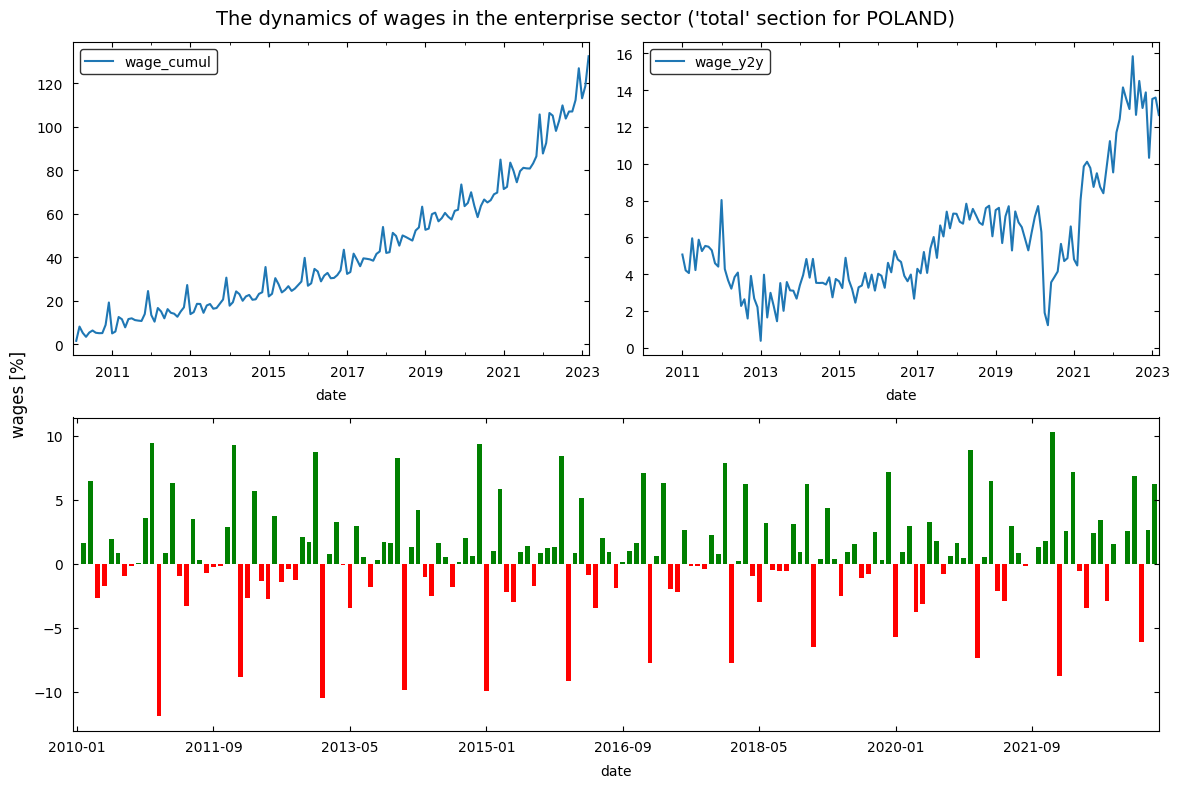

In [10]:
# total wages in Poland
wages_m_TOT = wages_m.query('voivodeship == "POLAND" and section == "total"')

fig, axes = plt.subplot_mosaic("AB;CC", figsize=(12, 8))

# plot the cumul and y2y indices 
for w_i, ax in zip(['wage_cumul', 'wage_y2y'], ['A', 'B']):
    wages_m_TOT.plot(
        y=w_i, ax=axes[ax]
    )

# plot the m2m index (the bar plot)
wages_m_TOT.wage_m2m.plot.bar(
    width=0.7, 
    color=np.where(wages_m_TOT.wage_m2m > 0, 'g', 'r'), 
    ax=axes['C']
)
axes['C'].xaxis.set_major_locator(plt.MaxNLocator('auto'))
axes['C'].xaxis.set_tick_params(rotation=0)

plt.suptitle('The dynamics of wages in the enterprise sector '
             '(\'total\' section for POLAND)', fontsize=14)
fig.supylabel('wages [%]')
fig.tight_layout()

<a id='cell_wages_tot'></a>
The cumulative plot (in the top left corner) shows, that the wages increased in general, exceeding the level of 120% growth in relation to Jan 2010. On the other hand, the curve in the top right corner in the figure allows to trace the year-to-year changes. In this case, the majority of indices remained below 8%, and after a rapid decline in the few first months of 2020 (the beginning of the COVID-19 pandemic in Poland), the year-to-year wages started to increase again, reaching the peak of 16% in 2022. It should be noted, that since all the values are above the zero level, the wage in any chosen month was always higher than the wage one year before (the curve indicates the pace of year-to-year growths).

The dynamics is more complex for the month-to-month indices (the bottom graph in the figure), where we can see both increases (green) and decreases (red), indicating a high variability of the wages. The highest changes are observed for December and January months, which relates to the annual bonuses in the enterprises. The same phenomenon can be also noticed in the ending/beginning months of the quarters (quarterly bonuses), but on a smaller scale. The example of variations in December and January within chosen years is shown below.

In [11]:
wages_m_TOT[wages_m_TOT.index.month.isin([12, 1])].wage_m2m.head(9)

date
2010-01      NaN
2010-12     9.44
2011-01   -11.91
2011-12     9.25
2012-01    -8.86
2012-12     8.76
2013-01   -10.49
2013-12     8.30
2014-01    -9.86
Freq: M, Name: wage_m2m, dtype: float64

The effect of month-to-month fluctuations can be observed for any of the enterprise sections available; some of the examples are presented in the next cell (limited to [2018, 2023] for clarity). Due to different character of particular branches of the sector, it is hard to determine any strict patterns between the indices.

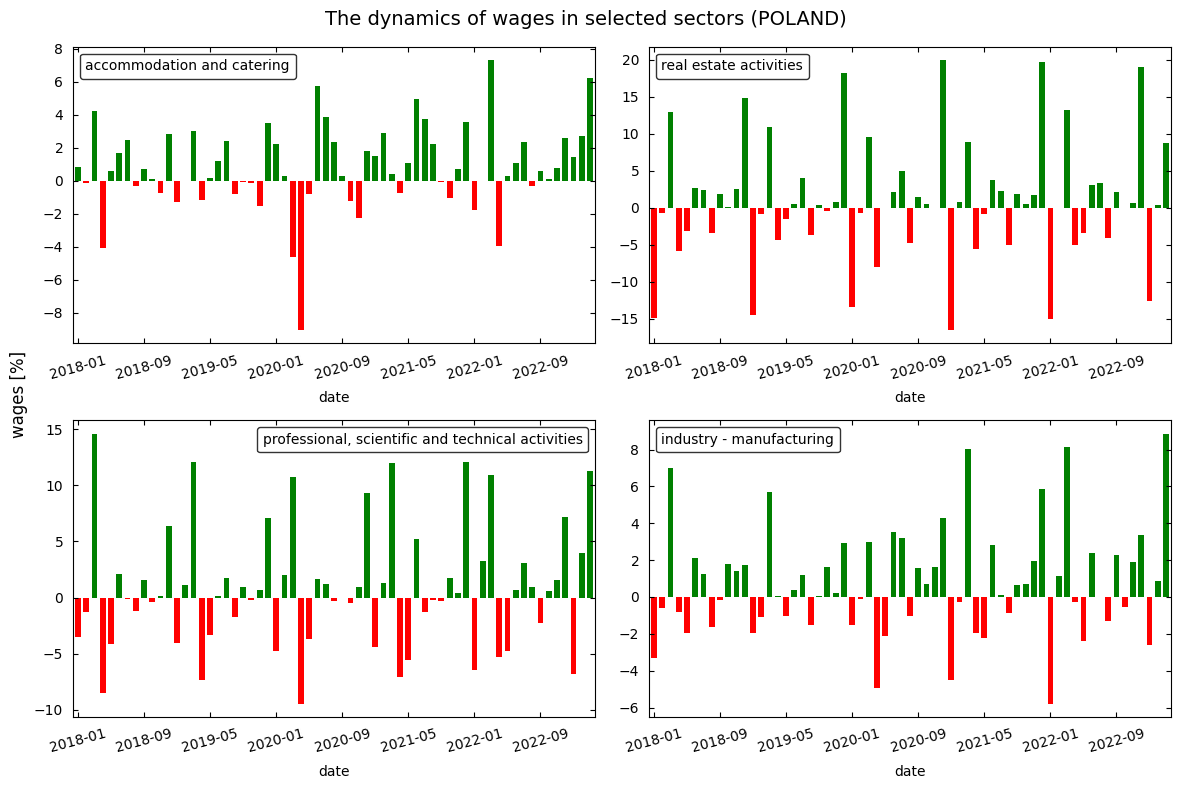

In [12]:
from utils import label_shorthands

# select enterprise sections
sections = label_shorthands(wages_m, ['accommodation', 'estate', 
    'scientific', 'manufacturing'], 'section')

# grab the data regardless the voivodeships
wages_m_POL = wages_m.query('voivodeship == "POLAND"')
wages_m_POL_m2m_18_23 = wages_m_POL[wages_m_POL.index.year >= 2018].pivot(
    columns='section', 
    values='wage_m2m'
)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# plot the m2m indices
for sec, ax in zip(sections, axes.flatten()):
    wages_m_POL_m2m_18_23[sec].plot.bar(
        color=np.where(wages_m_POL_m2m_18_23[sec] > 0, 'g', 'r'), 
        width=0.7, legend=True, ax=ax
    )
    ax.legend(handlelength=0, handletextpad=0)
    ax.xaxis.set_major_locator(plt.MaxNLocator('auto'))
    ax.xaxis.set_tick_params(rotation=15)

plt.suptitle('The dynamics of wages in selected sectors (POLAND)', fontsize=14)
fig.supylabel('wages [%]')
fig.tight_layout()

To alleviate the problem of month-to-month variability, it will be easier to operate with the year-to-year indices. In the cell below we compare the indicators between the sections, using the same fixed scale (in the vertical axis; the grid lines are added for readability).

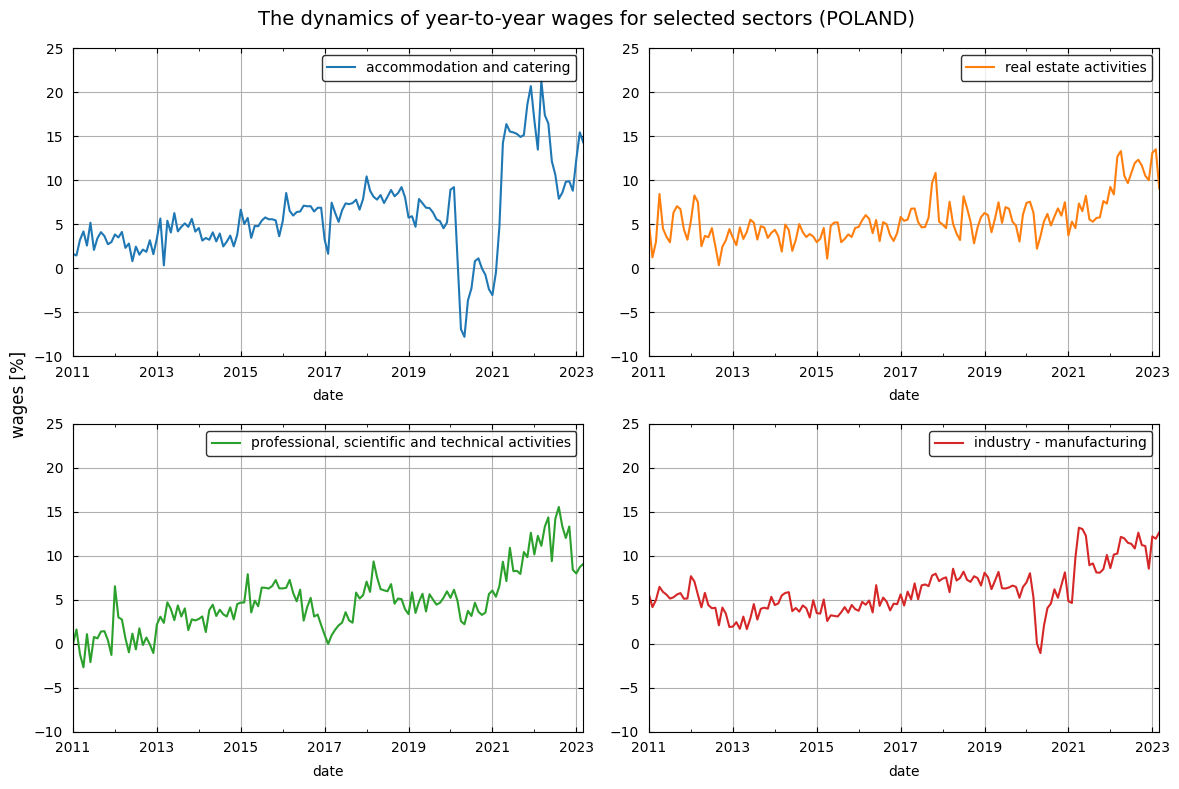

In [13]:
# filter the data for chosen sections
wages_m_POL_y2y = wages_m_POL.pivot(
    columns='section', 
    values='wage_y2y'
).filter(items=sections)

# plot the y2y indices
wages_m_POL_y2y.plot(
    subplots=True, layout=(2, 2), 
    xlim=pd.Period('2011-01'), ylim=(-10, 25), 
    grid=True, sharex=False, figsize=(12, 8)
)

plt.suptitle('The dynamics of year-to-year wages '
    'for selected sectors (POLAND)', fontsize=14)
plt.gcf().supylabel('wages [%]')
plt.tight_layout()

As one can see, the COVID-19 pandemic in 2020 had a huge impact on the <font color=#ff7f0e>accommodation and catering</font> branch (see the decline of the blue curve). Beginning from 2021, the wages in this section started to increase rapidly. A similar scenario can be also observed for the <font color=#ff7f0e>manufacturing</font> section (the red curve) but on a smaller scale. On the other hand, the indices for the <font color=#ff7f0e>real estate activities</font> remained quite stable, oscillating around 5% as shown by the orange diagram.

To evaluate the final changes, we can compare the cumulative indices (the **wage_cumul** column) from 2023-02 (one month prior to the quarter end to exclude the impact of possible bonus), observing which sections developed the most from the beginning of 2010. The results are presented in the left panel in the figure below. We also include the absolute wages in Feb 2023 for comparison (in the right panel).

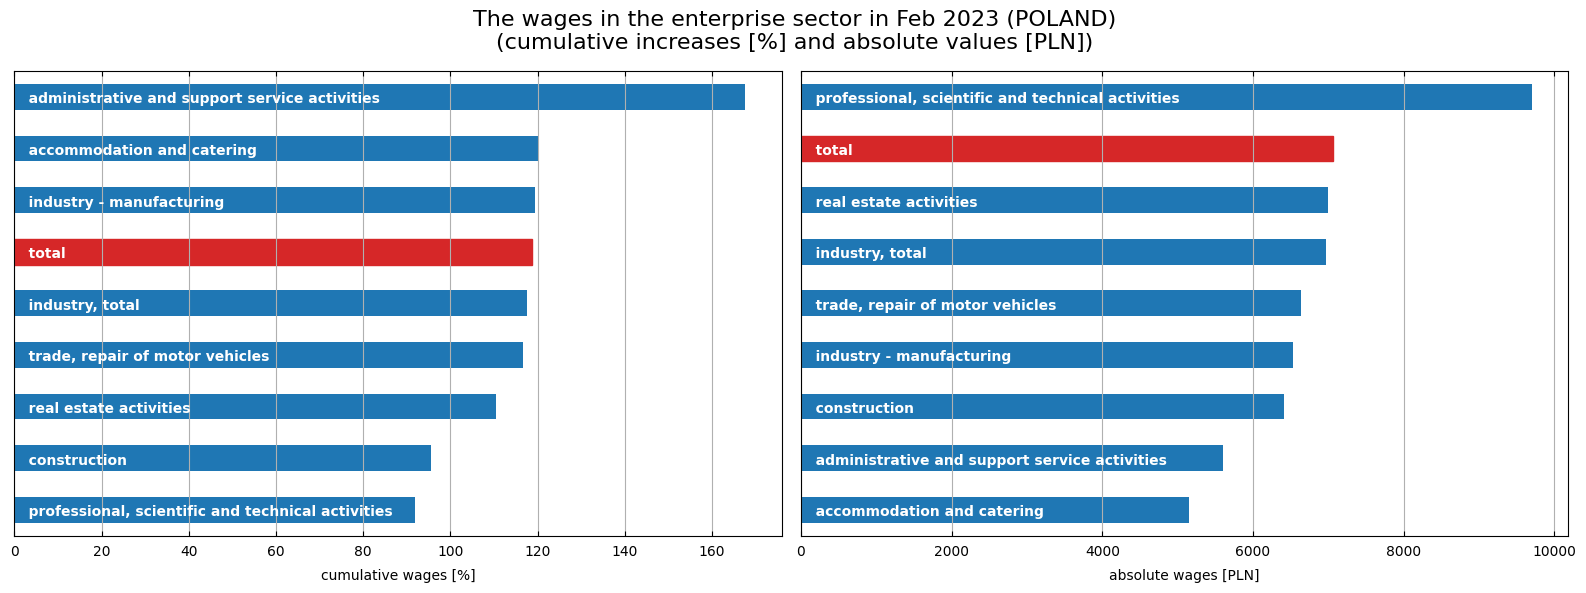

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# plot the cumulative indices and the absolute wages
for ax, wage_type, xlabel in zip(axes, ['wage_cumul', 'wage'], 
    ['cumulative wages [%]', 'absolute wages [PLN]']):
    wages_m_POL.loc[pd.Period('2023-02')].sort_values(wage_type).plot(
        kind='barh', 
        x='section', y=wage_type, 
        legend=False, ylabel='', xlabel=xlabel, ax=ax
    )
    ax.grid(axis='x')
    
    for patch, label in zip(ax.patches, ax.get_yticklabels()):
        label = '   ' + label.get_text()
        ax.text(
            patch.get_x(), 
            patch.get_y() + patch.get_height() / 4, 
            label, weight='bold', color='w'
        )
        if label.lstrip() == 'total':
            patch.set(color='tab:red')
    
    ax.set(yticklabels='', yticks=[])

fig.suptitle('The wages in the enterprise sector in Feb 2023 (POLAND)\n'
    '(cumulative increases [%] and absolute values [PLN])', fontsize=16)
fig.tight_layout()

<a id='cell_wages_q'></a>
As can be seen in the left panel, the <font color=#ff7f0e>administrative and support service activities</font> section noted the highest percentage increase of the wages, reaching the growth above 160%. The average increase (<font color=#ff7f0e>total</font>, across all sections) got close to the 120% level, while the <font color=#ff7f0e>professional, scientific and technical activities</font> branch developed the least, slightly above 90%. However, the understanding of the data changes completely when we compare the absolute wages between the sections (shown in the right panel). In this scenario, the <font color=#ff7f0e>professional, scientific and technical activities</font> can be found in the top position, with the result close to 10 000 [PLN]. The <font color=#ff7f0e>administrative and support service activities</font>, where the wages technically increased the most, are now penultimate, below 6 000 [PLN].

The observed results emphasize, that the analysis of the wealth and its dynamics among the consumers should include both their salary adjustments, as well as actual wages. Using our data, we can split the latter ones by voivodeships and enterprise sections. To smooth the fluctuations occurring between the months, let us aggregate the wages using quarter averages.

In [15]:
# wages per section, voivodeship and quarter
wages_Q = wages.groupby(['section', 'voivodeship', pd.Grouper(freq='Q')])\
    .wage.mean().unstack([0, 1])

# the sample of aggregated wages for the 'total' section
wages_Q['total'].head(12)

voivodeship,DOLNOSLASKIE,KUJAWSKO-POMORSKIE,LODZKIE,LUBELSKIE,LUBUSKIE,MALOPOLSKIE,MAZOWIECKIE,OPOLSKIE,PODKARPACKIE,PODLASKIE,POLAND,POMORSKIE,SLASKIE,SWIETOKRZYSKIE,WARMINSKO-MAZURSKIE,WIELKOPOLSKIE,ZACHODNIOPOMORSKIE
date,,,,,,,,,,,,,,,,,
2010Q1,3215.19,2763.73,2842.55,2707.60,2719.47,3007.57,4284.76,2953.05,2666.11,2795.80,3336.49,3339.46,3536.82,2765.44,2631.12,3024.73,2972.11
2010Q2,3470.34,2816.72,2839.07,2766.05,2836.89,3080.26,4298.13,3016.42,2708.29,2820.62,3383.93,3320.48,3512.97,2900.32,2674.78,3109.50,3014.37
2010Q3,3415.84,2885.87,2965.66,2890.80,2852.73,3118.84,4260.51,3063.22,2774.42,2922.55,3412.64,3399.23,3564.04,2930.35,2756.28,3148.24,3087.53
2010Q4,3618.49,2943.24,3227.78,3161.82,2981.93,3226.76,4366.37,3215.51,2903.48,2993.87,3590.50,3512.06,4032.35,2998.01,2891.22,3259.28,3165.96
2011Q1,3340.45,2861.11,3060.63,3009.60,2823.23,3187.38,4481.26,3085.40,2797.25,2865.00,3484.38,3402.47,3681.86,2872.79,2761.33,3174.20,3024.45
2011Q2,3641.48,2965.97,3070.74,2983.97,2932.21,3277.26,4465.25,3161.92,2876.59,2951.91,3565.08,3591.46,3806.62,2985.68,2803.30,3234.06,3118.46
2011Q3,3572.50,3010.71,3214.70,3102.22,2993.08,3281.22,4455.53,3183.09,2922.00,3069.43,3597.79,3598.04,3861.22,3038.54,2908.28,3283.47,3198.03
2011Q4,3793.45,3106.53,3382.60,3321.36,3108.72,3382.22,4579.21,3315.42,3031.70,3189.88,3761.01,3680.17,4218.14,3152.01,3002.94,3411.08,3309.30
2012Q1,3523.84,3043.72,3257.28,3163.37,2997.65,3383.16,4552.07,3239.20,2952.06,3061.21,3668.46,3655.12,3902.94,3062.41,2945.35,3352.04,3209.52


Using aggregated wages, we can easily visualize the differences between chosen voivodeships and enterprise sections. Note the difference in scale of the vertical axes in the subplots below.

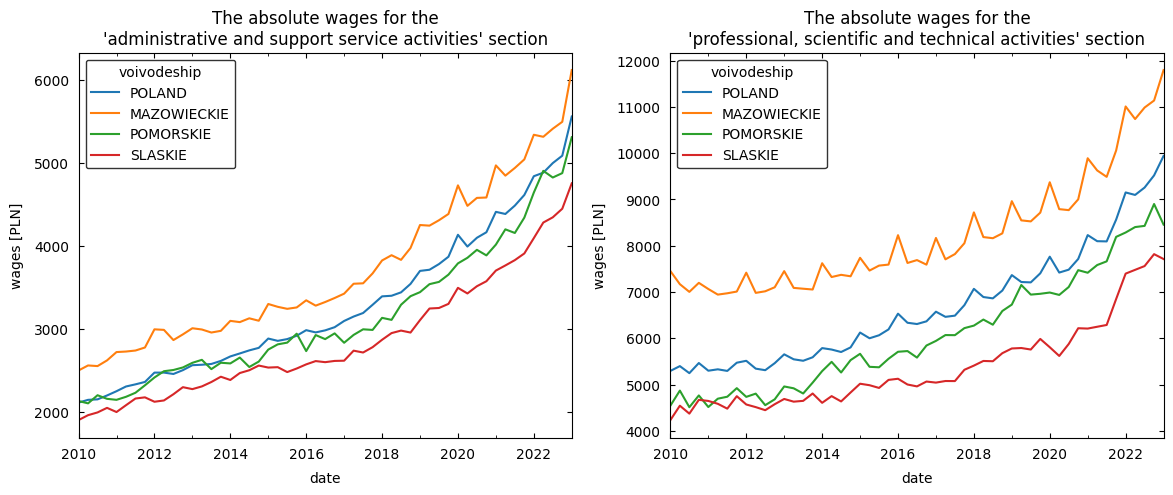

In [16]:
# the voivodeships and the sections to compare
voivs = ['POLAND', 'MAZOWIECKIE', 'POMORSKIE', 'SLASKIE']
secs = ['administrative and support service activities', 
        'professional, scientific and technical activities']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, sec in zip(axes, secs):
    wages_Q[sec][voivs].plot(
        title='The absolute wages for the\n\'' + sec + '\' section', 
        ylabel='wages [PLN]', ax=ax 
    )

To examine the basic statistics of the categories, we will group the data frame and aggregate the year-to-year indices with minimum, maximum and mean across the whole time interval. We drop the missing values from the data, which correspond to 2010 (the first year-to-year index is calculated for Jan 2011).

In [17]:
wages_m.dropna().groupby(['section', 'voivodeship']).wage_y2y\
    .agg(['min', 'max', 'mean']).unstack(0)

min  \
section             accommodation and catering   
voivodeship                                      
DOLNOSLASKIE                            -11.99   
KUJAWSKO-POMORSKIE                      -20.29   
LODZKIE                                 -14.22   
LUBELSKIE                                -9.87   
LUBUSKIE                                -16.39   
MALOPOLSKIE                              -8.33   
MAZOWIECKIE                             -10.54   
OPOLSKIE                                 -6.16   
PODKARPACKIE                            -10.86   
PODLASKIE                               -10.70   
POLAND                                   -7.82   
POMORSKIE                                -6.66   
SLASKIE                                  -3.97   
SWIETOKRZYSKIE                           -5.86   
WARMINSKO-MAZURSKIE                     -25.49   
WIELKOPOLSKIE                            -7.63   
ZACHODNIOPOMORSKIE                      -11.00   

                                                                   \
section             administrative and support service activities   
voivodeship                                                         
DOLNOSLASKIE                                                -3.04   
KUJAWSKO-POMORSKIE                                          -8.62   
LODZKIE                                                     -3.99   
LUBELSKIE                                                  -23.62   
LUBUSKIE                                                   -13.88   
MALOPOLSKIE                                                 -9.92   
MAZOWIECKIE                                                 -4.26   
OPOLSKIE                                                   -35.45   
PODKARPACKIE                                                 0.44   
PODLASKIE                                                   -4.89   
POLAND                                                       1.06   
POMORSKIE                                                   -7.40   
SLASKIE                                                     -2.35   
SWIETOKRZYSKIE                                             -16.19   
WARMINSKO-MAZURSKIE                                        -13.52   
WIELKOPOLSKIE                                               -5.03   
ZACHODNIOPOMORSKIE                                         -16.15   

                                                                           \
section             construction industry - manufacturing industry, total   
voivodeship                                                                 
DOLNOSLASKIE              -11.82                    -2.08          -19.31   
KUJAWSKO-POMORSKIE         -3.00                    -0.42           -0.17   
LODZKIE                    -8.53                    -0.42           -3.84   
LUBELSKIE                  -6.06                    -2.18          -14.18   
LUBUSKIE                   -9.55                    -3.85           -3.98   
MALOPOLSKIE                -9.62                    -2.06           -1.52   
MAZOWIECKIE               -12.29                    -2.50           -2.82   
OPOLSKIE                  -12.16                    -1.14           -1.66   
PODKARPACKIE               -7.11                    -1.83           -1.78   
PODLASKIE                  -8.79                    -7.27           -6.73   
POLAND                     -4.52                    -1.07           -0.71   
POMORSKIE                  -4.22                    -1.30           -8.33   
SLASKIE                    -4.52                    -5.26           -9.84   
SWIETOKRZYSKIE             -5.92                    -2.79           -4.75   
WARMINSKO-MAZURSKIE        -6.48                    -2.52           -1.77   
WIELKOPOLSKIE              -5.96                    -2.21           -1.84   
ZACHODNIOPOMORSKIE         -5.76                     0.33           -3.61   

                                                                       \
section             professional, scientific an

If required, we can easily filter a grouped data frame to exclude the cases of no interest. We will us this method to indicate the pairs of voivodeships and sections, for which the year-to-year indices remained above the zero level throughout the whole considered time frame. In these cases, the wage in any chosen month was always higher than in the month one year prior (as we have already observed for the <font color=#ff7f0e>total</font> section across <font color=#ff7f0e>POLAND</font>; see [this](#cell_wages_tot) cell above for details).

The result for each pair (voivodeship, section) determines the lowest year-to-year percentage increase of the wages within the [2011, 2023] time frame.

In [18]:
wages_m.dropna().groupby(['voivodeship', 'section'])\
    .filter(lambda x: x.wage_y2y.min() > 0)\
    .groupby(['voivodeship', 'section']).wage_y2y.min()

voivodeship          section                                      
KUJAWSKO-POMORSKIE   total                                           0.71
LODZKIE              total                                           0.38
PODKARPACKIE         administrative and support service activities   0.44
                     total                                           0.23
                     trade, repair of motor vehicles                 1.04
POLAND               administrative and support service activities   1.06
                     real estate activities                          0.33
                     total                                           0.38
                     trade, repair of motor vehicles                 1.02
WARMINSKO-MAZURSKIE  trade, repair of motor vehicles                 0.00
WIELKOPOLSKIE        total                                           0.21
ZACHODNIOPOMORSKIE   industry - manufacturing                        0.33
Name: wage_y2y, dtype: float64

The comparison between the voivodeships can be visualized more clearly with the `geopandas` module and the spatial data. We have already used both in the previous notebook to show how the inflation varied across different regions, and we can use similar methods to denote the wages. The `inflation_map` function (see the <a href='utils.py'>`utils.py`</a> module) allows to present the data on the map of Poland, but it requires specific names of columns, since it was originally developed for the inflation data. Instead of adjusting (and possibly expanding) the function code, we can easily prepare a draft data frame of the wages with the columns renamed, according to the requirements.

The maps enclosed below present the comparison of the absolute wages across the whole country between Jan 2010 and Jan 2023 (the case of average wages in the enterprise sector - the <font color=#ff7f0e>total</font> section). By changing the function arguments, we can easily compare any type of indices (m2m, y2y or cumul) within any chosen section.

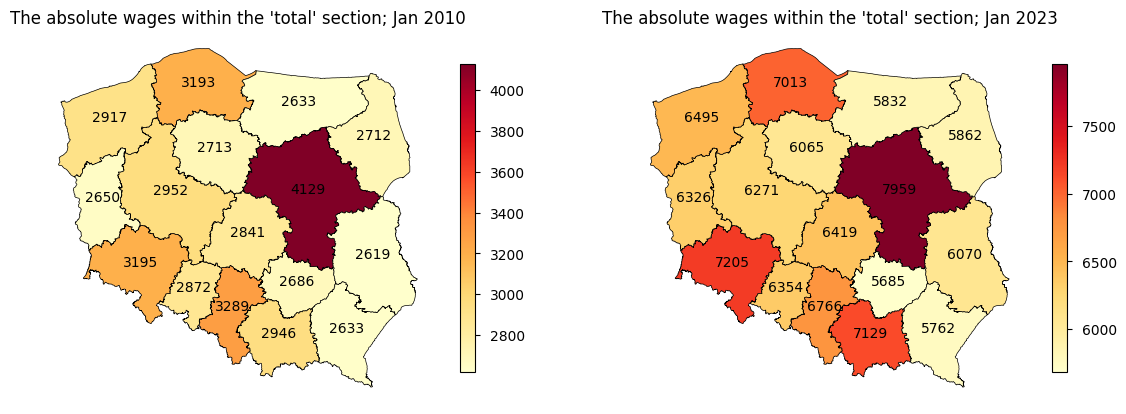

In [19]:
from utils import voivs_gdf

# collect the spatial data
voiv_map_gdf = voivs_gdf()

"""
Prepare the frame with the headers changed for the `inflation_map` easier use. 
We will use the q2q marker to denote the absolute wages 
and cut the decimals for map readability.
"""
wages_gdf = voiv_map_gdf.merge(wages_m.reset_index(), how='right', 
    on='voivodeship').set_index('date').dropna(subset='geometry')\
    .astype({'wage': 'int'})\
    .rename({'section': 'good', 'wage': 'wage_q2q'}, axis=1)
wages_gdf.columns = wages_gdf.columns.str.replace('wage', 'inflation')

from utils import inflation_map

fig, axes = plt.subplots(1, 2, figsize=(14, 10))

# plot the maps
ax0 = inflation_map(wages_gdf, '2010-01', 'total', ax=axes[0])
ax1 = inflation_map(wages_gdf, '2023-01', 'total', ax=axes[1])

# improve the titles
ax0.set_title('The absolute wages within the \'total\' section; Jan 2010')
ax1.set_title('The absolute wages within the \'total\' section; Jan 2023');

The maps show, that the leading voivodeship hasn't changed, i.e., the largest wages can be still observed in <font color=#ff7f0e>MAZOWIECKIE</font> region. However, based on the color scale and its distribution across the voivodeships, it seems that the differences between them decreased (see, e.g., the eastern part of the country, where the wages got closer to the ones in the central and the western regions).

We will conclude this section with a simple analysis of the month-to-month wages distribution. As we have observed before, the wages fluctuate meaningfully, depending on the part of the year and possible quarter/annual bonuses. We can split each quarter into three equal parts and investigate how the wages differ between them.

Namely, we will encode the dates in the data as follows:\
0 - the beginning of the quarter (months: January, April, ...),\
1 - the middle of the quarter (months: February, May, ...),\
2 - the end of the quarter (months: March, June, ...).

Separating the monthly indices within each class and calculating their distributions, we can easily observe the differences occurring within the quarter.

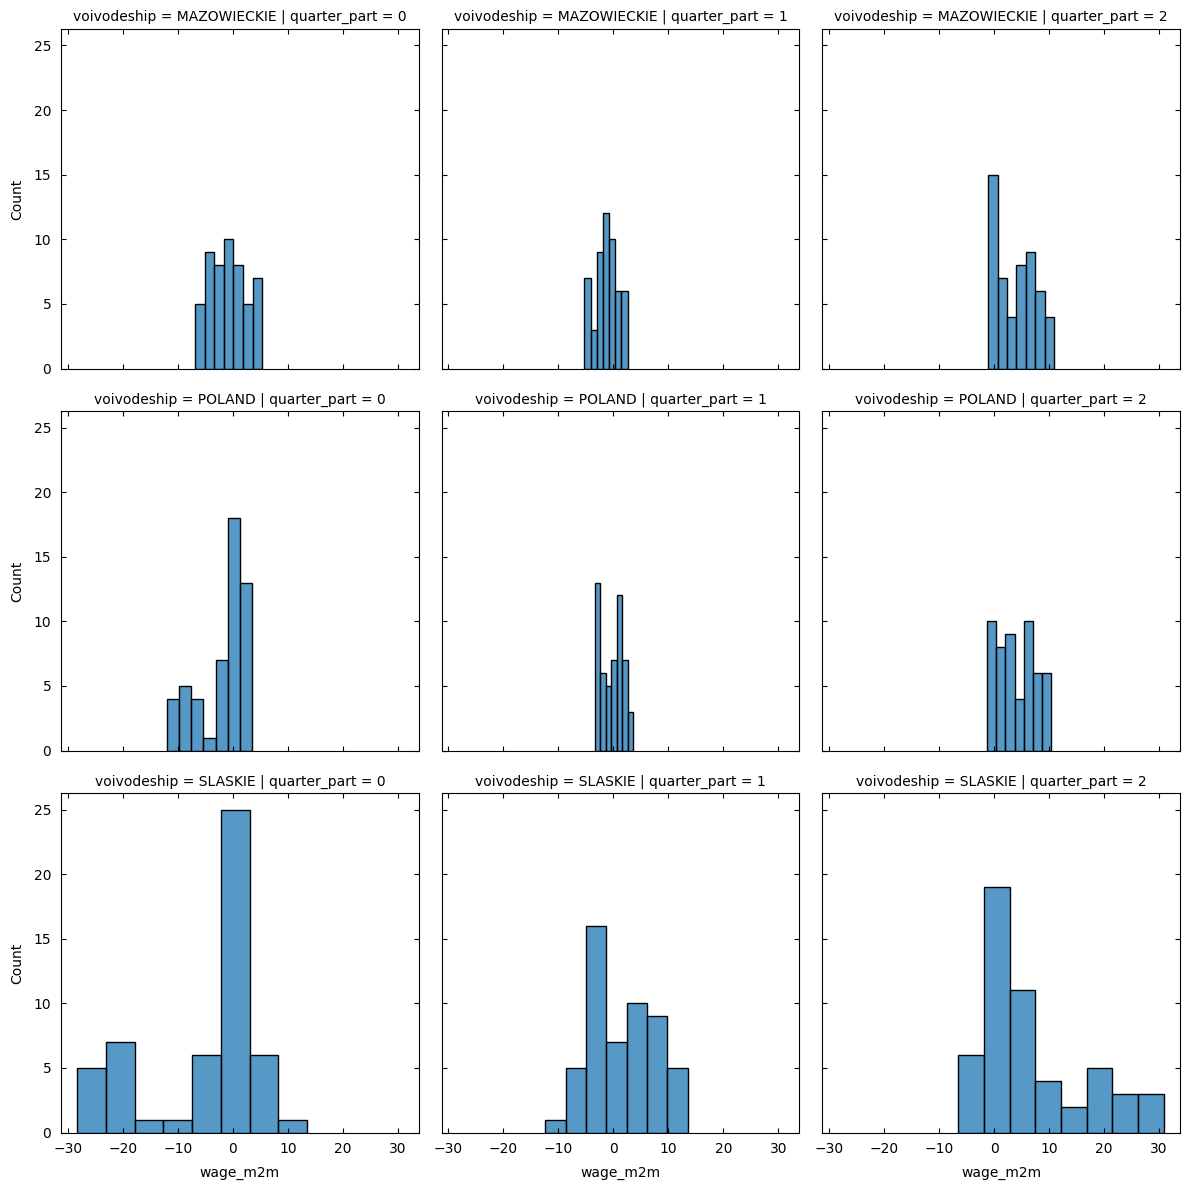

In [20]:
# encode the quarters for chosen voivodeships within the 'total' section
wages_m_Q_split = wages_m.query(
    'voivodeship.isin(["POLAND", "MAZOWIECKIE", "SLASKIE"]) '
    'and section == "total"'
    ).assign(quarter_part=lambda x: (x.index.month - 1) % 3)

# plot the histograms of the groups
grid_Q = sns.FacetGrid(
    data=wages_m_Q_split, 
    row='voivodeship', 
    col='quarter_part', 
    height=4, 
    row_order=["MAZOWIECKIE", "POLAND", "SLASKIE"]
)
grid_Q.map(sns.histplot, 'wage_m2m')

# improve the layout
for ax in grid_Q.axes.flatten():
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(True)

The title of each subplot includes the region name and chosen quarter part. As one can see, the histograms show the same pattern regardless the voivodeship. In the beginning of quarter (quarter_part = 0), the wages decrease compared to the previous month. Then, in the middle of quarter the situation stabilizes, i.e., the indices are more concentrated around zero. Finally, in the ending period we observe the shift towards positive values, when the wages increase (compared to the previous month).

The observed property can be also expressed by the averages of the month-to-month indices within different parts of quarters. In the cell presented below, we plot the means for chosen voivodeships (shown as the blue dots), including also their 95% confidence intervals, which are marked using horizontal sections. To estimate the intervals, we apply the bootstrap approach from the `scipy.stats` module (see the [SciPy bootstrap](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html) function for details).

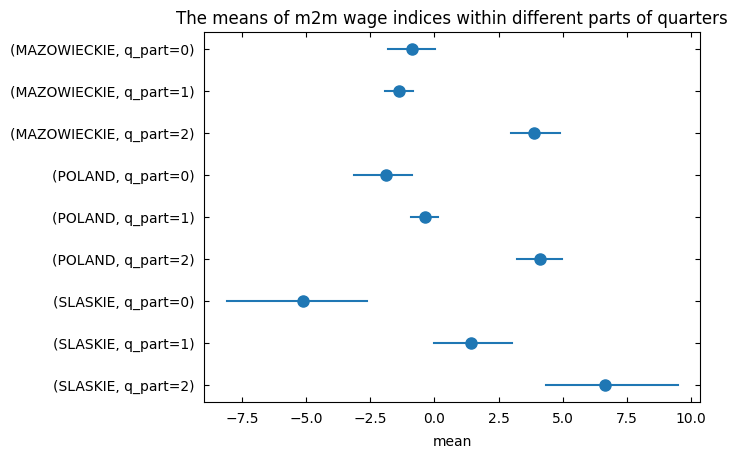

In [21]:
from scipy.stats import bootstrap

# the pivoted DataFrame
wages_m_Q_v = wages_m_Q_split.pivot(
    columns=['voivodeship', 'quarter_part'], values='wage_m2m'
    ).sort_index(axis=1)

# prepare the frame for the means and their confidence intervals
cols=['ci_l', 'avg', 'ci_r']
wages_bs = pd.DataFrame(columns=cols)

# collect the data
for col in wages_m_Q_v.columns:
    data = wages_m_Q_v[col].dropna(),
    c_i = bootstrap(data, np.mean, confidence_level=0.95, random_state=0)\
        .confidence_interval
    res = pd.Series([c_i.low, np.mean(data), c_i.high], index=cols, 
        name=f'({col[0]}, q_part={col[1]})')
    wages_bs = pd.concat([wages_bs, res.to_frame().T])

# plot the results
plt.plot(wages_bs.avg, wages_bs.index, 'o', markersize=8)

for lab, val in wages_bs.iterrows():
    plt.plot([val[0], val[2]], [lab, lab], c='tab:blue')

plt.gca().invert_yaxis()
plt.xlabel('mean')
plt.title('The means of m2m wage indices within different parts of quarters');

The obtained results confirm our previous observations, i.e., the highest growths are accumulated in the ending months of quarters. The distribution of values in the beginning and the middle of quarter depends on the region (see, e.g., <font color=#ff7f0e>MAZOWIECKIE</font> voivodeship, where the means in (q_part = 0) and (q_part = 1) are very close to each other), but in all cases, the values are smaller than the ones from the ending periods. The phenomenon is also confirmed by the confidence intervals, which indicate the separation of the classes.

The described scenario seems general and can be also observed in other sections of the enterprise sector.

### Wages and inflation

In this section we investigate the relations between the wages and the inflation data, starting from the monthly set.

As we have observed above, the month-to-month indices of wages can exhibit high fluctuations, depending on the part of the considered quarter; we will limit this problem by focusing on the year-to-year indicators only. Moreover, we narrow the data as follows:
- the wages will be constrained to the whole country case only (the <font color=#ff7f0e>POLAND</font> category in the **voivodeship** column), and
- the inflation will include the <font color=#ff7f0e>GRAND TOTAL</font> case of the households only (the label in the **household** column).

The first restriction is based on the fact, that the monthly inflation data is given regardless the voivodeships, which makes it more reasonable to compare it to the same category of the wages. The comparison including voivodeships can be performed for the quarterly inflation data, which has been shown further (see the ['Wages and prices'](#section_prices) section for details). The second restriction takes into account, that the wages have been collected for one specific sector of employment (the enterprises) and some of the households may have a small contribution in it (e.g., the retiree ones). Moreover, in the further part of the analysis we combine the wages with the quarterly inflation data, which is given regardless the household type.

We begin with querying the <a href='inflation_database.db'>`inflation_database.db`</a> for the inflation dataset and its transformations. Since the final indices will be only year-to-year, we exclude the NaNs prior to 2010-12, including also the latter date, since the earliest year-to-year index for the wages corresponds to 2011-01.

In [22]:
# query for the inflation data
with sqlite3.connect('inflation_database.db') as connection:
    infl_m = pd.read_sql(
        """
        SELECT *
        FROM inflation_monthly
        WHERE household == 'GRAND TOTAL'
        """,
        connection, index_col='date', parse_dates='date'
    ).to_period('M')

# transform the inflation data frame
infl_y2y = calculate_indices(infl_m, ['household', 'good'], 
    new_tfs=['y2y']).drop(columns=['household', 'inflation_m2m'])
infl_y2y = infl_y2y[infl_y2y.index > '2010-12']

The data frame of the wages has been already loaded during the dynamics analysis, so after selecting <font color=#ff7f0e>POLAND</font> region, we need to drop unnecessary columns only. Having the frames processed, we can join them into one dataset.

In [23]:
# prepare the wages frame
wages_y2y = wages_m.query('voivodeship == "POLAND"')\
    .loc[:, ['section', 'wage_y2y']].dropna()

# join the frames and reorder for readability
y2y_df = infl_y2y.join(wages_y2y)
y2y_df.insert(y2y_df.shape[1] - 2, 'inflation_y2y', 
    y2y_df.pop('inflation_y2y'))

y2y_df.sample(5, random_state=0)

,good,section,inflation_y2y,wage_y2y
date,,,,
2018-06,Cheese and curd,construction,2.21,9.27
2021-05,Food,"professional, scientific and technical activities",1.06,7.12
2022-08,Out-patient services,"trade, repair of motor vehicles",15.23,11.71
2015-05,RECREATION AND CULTURE,accommodation and catering,1.09,4.81
2021-12,Processed meat and other meat preparations,"trade, repair of motor vehicles",2.52,14.44


Let's start the comparison with simple line and scatter plots, which show how the indices changed in time and outline possible relations between them. The `infl_wag_plot` function from the <a href='utils.py'>`utils.py`</a> module can be used to produce the graphs for any type of good and section, within the selected time frame. In the cell below we present the most general comparison of the indices (good as <font color=#ff7f0e>GRAND TOTAL</font> and section as <font color=#ff7f0e>total</font>), for all the available dates.

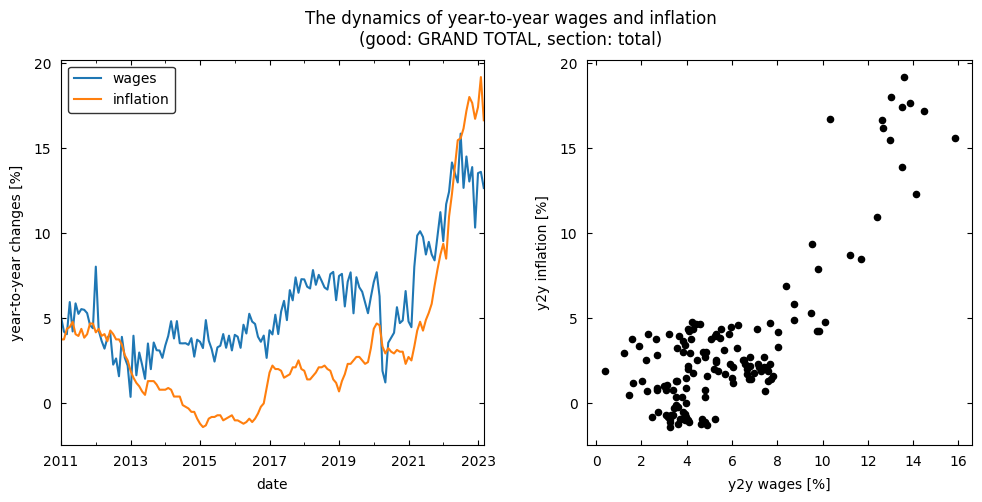

In [24]:
from utils import infl_wag_plot

infl_wag_plot(y2y_df);

The line plots included in the LHS of the figure show, that before 2022, the year-to-year wages were higher than the inflation in a vast majority of months. The situation reversed in 2022, due to the abnormal inflation rates. The curves indicate, that there is no strict relation between the indices, which can be also observed in the scatter diagram in the RHS of the figure. The data form rather a fuzzy cloud of points (except for the ones in the upper right part of the plot - the highest values within 2022-2023), excluding any recognizable pattern.

In order to sketch the general perspective on the wages/inflation situation, we can mark each record in the data with a binary flag, informing if the year-to-year wage index exceeded the inflation (flag = 1), or vice versa (flag = 0). Having the data frame annotated (see the additional **wage_above_infl** column), we can aggregate the data, and for each pair *(section, good)*, determine the ratio of months, when the wage indices were higher than the inflation ones (involves all the months within [2011-2023] interval). The results are given below as follows:

In [25]:
# add the flags
y2y_df = y2y_df.assign(
    wage_above_infl=lambda x: np.where(x.wage_y2y > x.inflation_y2y, 1, 0)
)

# create the frame with ratios
y2y_df_ratios = y2y_df.pivot_table(
    index='good', columns='section', 
    values='wage_above_infl', 
    aggfunc=lambda x: x.sum()/x.count()
)
y2y_df_ratios

section,accommodation and catering,administrative and support service activities,construction,industry - manufacturing,"industry, total","professional, scientific and technical activities",real estate activities,total,"trade, repair of motor vehicles"
good,,,,,,,,,
ALCOHOLIC BEVERAGES AND TOBACCO,0.68,0.95,0.71,0.85,0.76,0.63,0.81,0.76,0.75
Actual rentals for housing,0.73,0.90,0.71,0.86,0.80,0.59,0.81,0.86,0.86
Alcoholic beverages,0.88,0.97,0.82,0.95,0.90,0.82,0.94,0.96,0.97
"Articles for personal hygiene and wellness, esoteric products and beauty products",0.72,0.84,0.83,0.82,0.82,0.83,0.85,0.84,0.85
"Audio-visual, photographic and information processing equipment",0.96,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...
Telephone and telefax equipment and telephone and telefax services,0.88,0.99,0.84,0.94,0.90,0.83,0.91,0.92,0.95
Tobacco,0.59,0.67,0.56,0.61,0.55,0.52,0.59,0.60,0.60
Transport services,0.68,0.83,0.64,0.73,0.71,0.63,0.73,0.71,0.69


Narrowing the obtained data frame to the <font color=#ff7f0e>total</font> section only (see the series below), we can see, that the growths of wages always exceeded the changes of prices within the <font color=#ff7f0e>household appliances</font>, <font color=#ff7f0e>audio-visual</font> equipment, <font color=#ff7f0e>clothing and footwear</font> or <font color=#ff7f0e>purchase of vehicles</font>. On the other hand, only in about 50 percent of the months, the wages changed greater than the increases of the <font color=#ff7f0e>sugar</font> price. A similar scenario can be also observed for the <font color=#ff7f0e>butter</font> (55%) or <font color=#ff7f0e>vegetables/fruits</font> (56%).

In [26]:
y2y_df_ratios['total'].sort_values(ascending=False)

good
Household appliances                                              1.00
CLOTHING AND FOOTWEAR                                             1.00
Footwear                                                          1.00
Audio-visual, photographic and information processing equipment   1.00
Purchase of vehicles                                              1.00
                                                                  ... 
Diesel oil                                                        0.57
Fruit                                                             0.56
Vegetables                                                        0.56
Butter                                                            0.55
Sugar                                                             0.50
Name: total, Length: 74, dtype: float64

We can indicate the cases (across all the sections), when the ratio got below 50%, i.e., there have been more months with the inflation exceeding the year-to-year wages than vice versa.

In [27]:
y2y_df_ratios.stack().loc[lambda x: x < 0.5].sort_values()

good                  section                                          
Medical services      professional, scientific and technical activities   0.44
Sugar                 construction                                        0.44
                      accommodation and catering                          0.46
                      professional, scientific and technical activities   0.46
Out-patient services  professional, scientific and technical activities   0.48
Bread                 professional, scientific and technical activities   0.49
Sugar                 industry, total                                     0.49
Bread                 construction                                        0.50
Oils and fats         construction                                        0.50
dtype: float64

As we have observed earlier, the <font color=#ff7f0e>professional, scientific and technical activities</font> section excels in the absolute wages, so even though the category appears above most often, its general wealth should stand on a good level. The wealth itself will be investigated in the further part of the notebook, where we compare the wages to the absolute prices of goods (see the ['Wages and prices'](#section_prices) section for details).

The ratios presented above can be visualized in the terms of absolute values and stacked horizontal bar plots. Below we present the results for the <font color=#ff7f0e>total</font> section of the enterprise sector and the main categories of goods (denoted using upper case). The number of total observations within each category is the same (the total number of available months), but split into number of months, when the wages/inflation exceeded the inflation/wages - blue and orange bars, respectively.

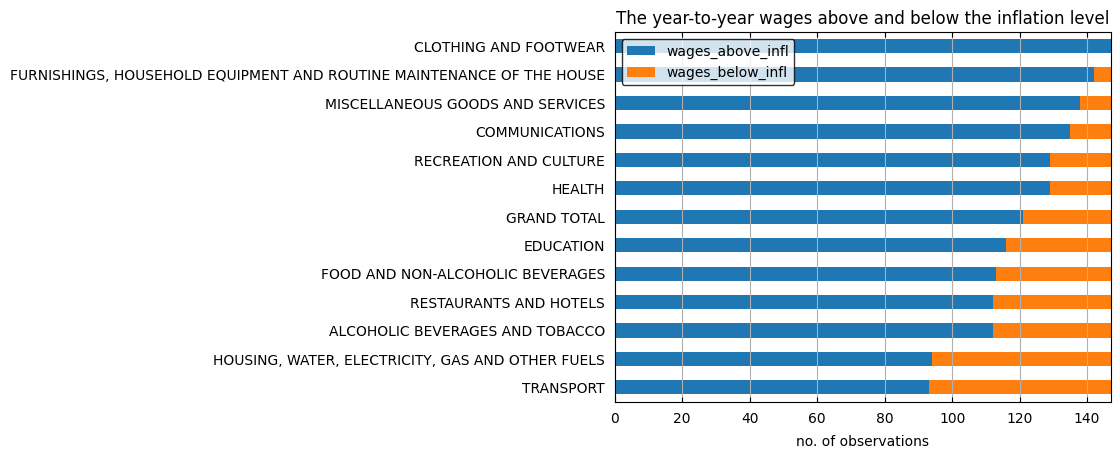

In [28]:
# the frame with the absolute sums of flags
y2y_df_above_below = y2y_df.groupby(['section', 'good']).wage_above_infl.agg(
    wages_above_infl=lambda x: x.sum(), 
    wages_below_infl=lambda x: x.count() - x.sum()
)

# the bar plot
ax = y2y_df_above_below.query(
    'section == "total" and good.str.upper() == good'
).droplevel(0).sort_values('wages_above_infl').plot(
    kind='barh', stacked=True, 
    ylabel='', xlabel='no. of observations', 
    title='The year-to-year wages above and below the inflation level'
)

ax.tick_params(axis='y', length=0)
ax.grid(axis='x')
ax.set_xlim(0, 12 * 12 + 3);

We can also determine the distribution of the differences between the year-to-year wages and inflation (difference within every month) using standard box plots. Each subplot shows the distributions for the selected category of goods (marked in the title), among different types of chosen enterprise sections (marked in the horizontal axis; the labels are abbreviated for figure compactness). Investigating the results within particular subfigure, we can compare the dynamics and basic statistics between the sections. The more the boxes are shifted towards positive values, the more year-to-year wage indices were higher than the inflation ones.

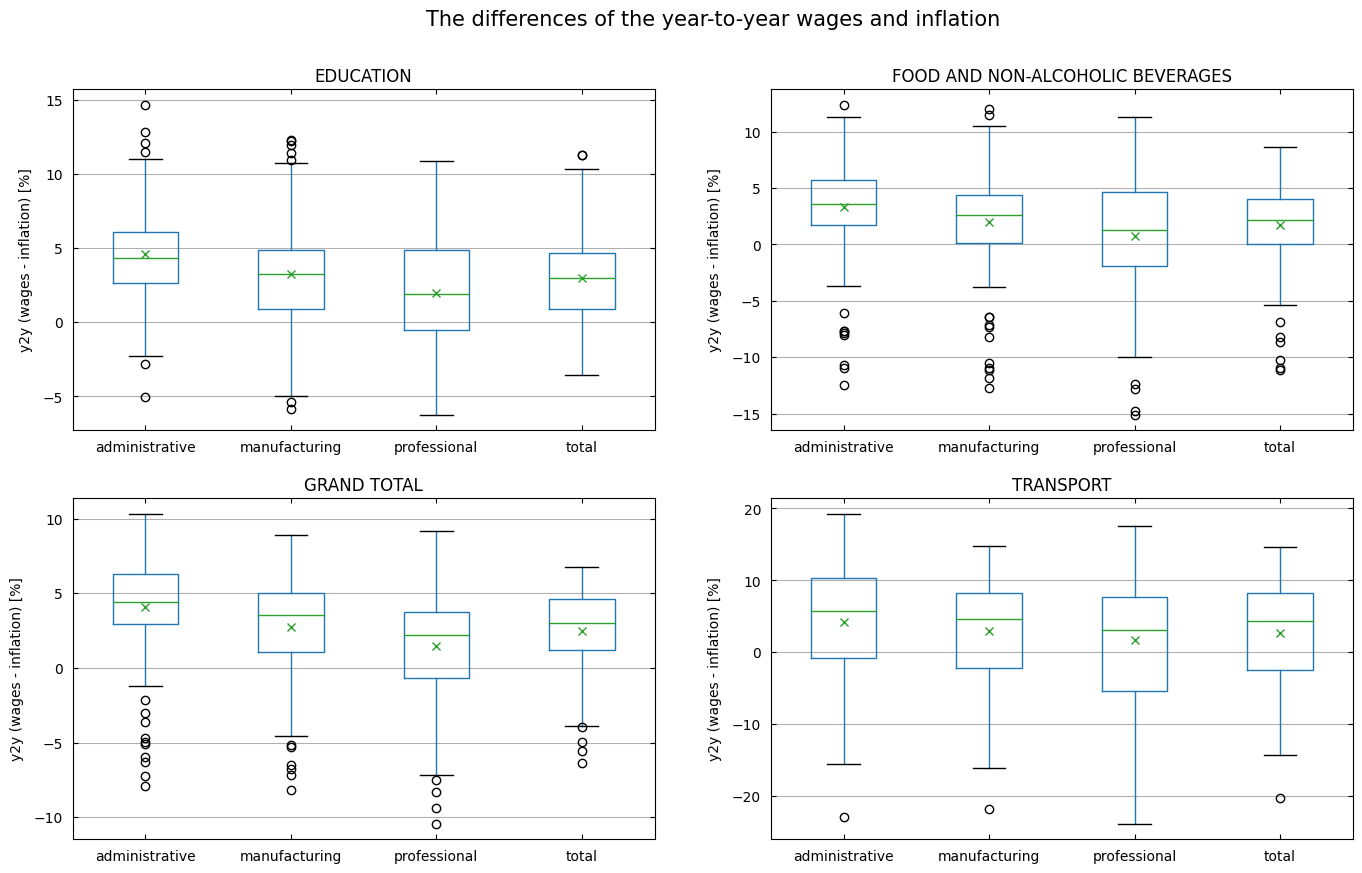

In [29]:
# grab the labels
secs_short = sorted(['total', 'professional',
    'administrative', 'manufacturing'])  # use shorthands for plots clarity
secs = label_shorthands(y2y_df, secs_short, 'section')
goods = label_shorthands(y2y_df, ['GRAND', 'FOOD', 'TRANSPORT', 'EDUCATION'], 
    'good')

# prepare the data frame
y2y_df_diff = y2y_df.query(f'good.isin({goods}) and section.isin({secs})')\
    .assign(wage_infl_diff=lambda x: x.wage_y2y - x.inflation_y2y)\
    .reset_index().pivot(
        index=['date', 'good'], columns='section', 
        values='wage_infl_diff'
    )
y2y_df_diff.columns = secs_short

# produce box plots
boxes = y2y_df_diff.groupby('good').boxplot(
    subplots=True, layout=(2, 2), figsize=(16, 10), 
    ylabel='y2y (wages - inflation) [%]', sharey=False, 
    showmeans=True, meanprops={'marker': 'x'}
)  # mark the means by 'x'

# clarify the figure
for box in boxes.values:
    box.grid(visible=False, axis='x')
plt.suptitle('The differences of the year-to-year wages and inflation', 
    fontsize=15);

The results discussed above involved the monthly inflation data, which were originally given regardless the voivodeships. To include the latter ones, we have to access the quarterly dataset and combine it with the wages resampled into quarter periods (the transformation is based on a simple 3-months mean; see also the `wages_Q` data frame [above](#cell_wages_q) for details). Then, for both datasets we will calculate the year-to-year indices, similarly to the previous (monthly) case. We also include the column of the differences between the wage and the inflation indices (the **wage_infl_diff** one) for easier analysis of regions.

**Note**: In the considered scenario, the granularity is decreased in comparison with the previously investigated case (here, we have only four records per year, since the year-to-year indices are based on the quarterly differences). Moreover, the upper date limit is equal to 2022-Q3.

The sample of the final data frame can be found in the cell below:

In [30]:
# query for quarterly inflation
with sqlite3.connect('inflation_database.db') as connection:
    infl_q = pd.read_sql('SELECT * FROM inflation_quarterly', 
        connection, index_col='date', parse_dates='date').to_period('Q')

# prepare the inflation frame
infl_Q_y2y = calculate_indices(infl_q, ['voivodeship', 'good'], 
    base_tf='q2q', new_tfs=['y2y']).drop(columns='inflation_q2q')
infl_Q_y2y = infl_Q_y2y[infl_Q_y2y.index > '2010Q4']

# prepare the wages frame
wages_Q_y2y = wages_Q.stack(level=[0, 1]).rename('wage')\
    .reset_index(level=[1, 2])
wages_Q_y2y = wages_Q_y2y.assign(
    wage_y2y=wages_Q_y2y.groupby(['section', 'voivodeship'])\
        .wage.pct_change(4)*100.0
).drop(columns='wage').dropna()

# merge the frames, add the differences column and reorder for readability
y2y_Q_df = infl_Q_y2y.merge(
    wages_Q_y2y, how='inner', on=['date', 'voivodeship']
).assign(wage_infl_diff=lambda x: x.wage_y2y - x.inflation_y2y)

y2y_Q_df.insert(
    y2y_Q_df.shape[1] - 2, 'inflation_y2y', y2y_Q_df.pop('inflation_y2y')
)

y2y_Q_df.sample(5, random_state=0)

,voivodeship,good,section,wage_y2y,inflation_y2y,wage_infl_diff
date,,,,,,
2019Q1,POLAND,EDUCATION,industry - manufacturing,7.26,3.03,4.23
2017Q4,WIELKOPOLSKIE,ALCOHOLIC BEVERAGES AND TOBACCO,administrative and support service activities,9.19,0.80,8.39
2017Q1,SLASKIE,RECREATION AND CULTURE,administrative and support service activities,1.72,-0.44,2.16
2013Q3,MALOPOLSKIE,HEALTH,real estate activities,4.56,1.31,3.25
2016Q2,OPOLSKIE,GRAND TOTAL,"professional, scientific and technical activities",-3.78,-1.00,-2.78


The basic dynamics of wage and inflation indices for chosen voivodeship, section and good can be determined by the `infl_wag_plot` function, which we have already used for the monthly data. In the example below, we compare the wages in the <font color=#ff7f0e>administrative and support service activities</font> section with the inflation of <font color=#ff7f0e>FOOD AND NON-ALCOHOLIC BEVERAGES</font>, where both indices correspond to <font color=#ff7f0e>LUBUSKIE</font> region. The line plots (in the left panel) show how the wages fluctuated (compared to the inflation values), including their rapid growths and declines in particular years. As in the previous scenario of the monthly data, there is no strict relation between the indicators, which can be observed in the right panel in the figure (see the included scatter diagram).

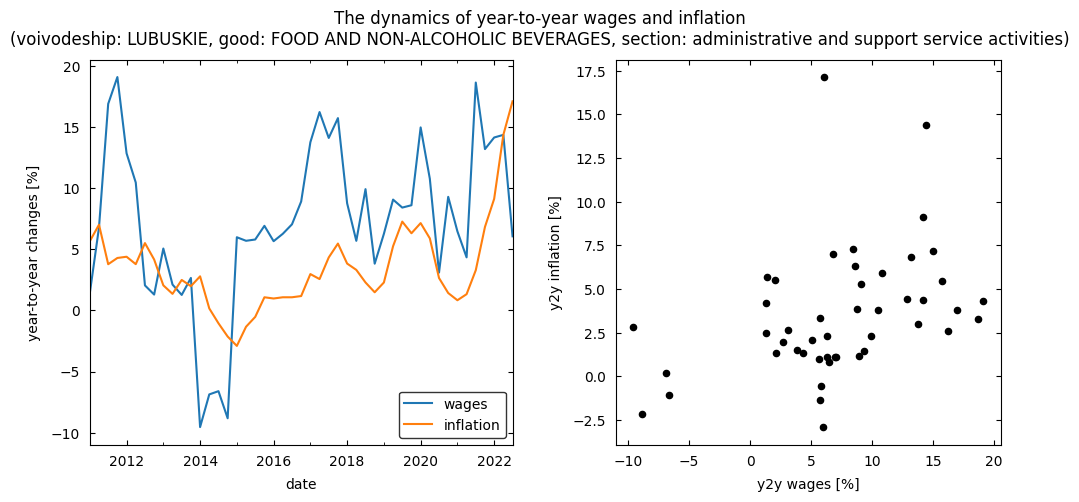

In [31]:
infl_wag_plot(y2y_Q_df, category='LUBUSKIE', 
    good='FOOD', section='administrative');

Since the quarterly data involves the voivodeships, we can easily compare the latter ones using the **wage_infl_diff** column. The values in the column indicate the absolute percentage differences between the year-to-year wage index and the inflation one (for each available quarter), and allow to see, if the wages increased faster (or slower) than the inflation. The more the differences shift towards positive values, the better consumers' situation. On the other hand, the negative values inform, that the improvement of the wages was below the inflation level.

A simple aggregation can involve the maximum and the minimum differences (with the quarters of their occurrence), across varied goods and voivodeships, and fixed enterprise section. In the frame enclosed below we present the comparison for the general case (the <font color=#ff7f0e>total</font> section), using the columns **diff_max** (the maximum) and **diff_min** (the minimum) - see the second level in the column MultiIndex. The time frame is limited to 2011-2021 and excludes the highest inflation increases in 2022 and 2023.

**Note**: Since the values in the **wage_infl_diff** column are given with high precision, we don't have to worry about possible ties within the results, which in this case are extremely unlikely.

In [32]:
min_max_diff_Q = y2y_Q_df[:'2021Q4'].query('section == "total"')\
    .groupby(['voivodeship', 'good']).wage_infl_diff.agg(
    diff_min = lambda x: (x.idxmin(), round(x.min(),2)), 
    diff_max = lambda x: (x.idxmax(), round(x.max(),2))
    ).unstack(1).swaplevel(axis='columns').sort_index(axis=1)
    
min_max_diff_Q

good                ALCOHOLIC BEVERAGES AND TOBACCO                   \
                                           diff_max         diff_min   
voivodeship                                                            
DOLNOSLASKIE                         (2021Q2, 9.39)  (2012Q3, -1.69)   
KUJAWSKO-POMORSKIE                  (2021Q2, 10.26)  (2012Q4, -2.72)   
LODZKIE                              (2021Q2, 9.64)  (2020Q2, -1.63)   
LUBELSKIE                            (2016Q1, 9.17)  (2013Q2, -2.72)   
LUBUSKIE                             (2021Q2, 12.6)  (2020Q2, -5.87)   
MALOPOLSKIE                          (2021Q2, 9.66)  (2012Q2, -2.56)   
MAZOWIECKIE                          (2021Q4, 8.16)  (2012Q3, -3.69)   
OPOLSKIE                             (2021Q4, 8.51)  (2012Q4, -4.05)   
PODKARPACKIE                        (2021Q2, 11.19)  (2020Q2, -3.36)   
PODLASKIE                            (2021Q2, 12.2)   (2020Q2, -2.8)   
POLAND                                (2021Q2, 8.2)  (2020Q2, -2.43)   
POMORSKIE                           (2021Q2, 11.08)  (2020Q2, -3.83)   
SLASKIE                              (2018Q2, 9.93)  (2020Q2, -4.82)   
SWIETOKRZYSKIE                       (2021Q2, 9.45)  (2020Q2, -6.99)   
WARMINSKO-MAZURSKIE                 (2021Q2, 12.14)  (2020Q2, -3.63)   
WIELKOPOLSKIE                        (2017Q4, 7.01)  (2014Q1, -2.93)   
ZACHODNIOPOMORSKIE                   (2021Q2, 7.95)  (2020Q2, -2.93)   

good                CLOTHING AND FOOTWEAR                        EDUCATION  \
                                 diff_max        diff_min         diff_max   
voivodeship                                                                  
DOLNOSLASKIE              (2017Q2, 17.32)  (2011Q2, 3.68)  (2014Q1, 13.88)   
KUJAWSKO-POMORSKIE        (2017Q3, 13.18)  (2016Q1, 5.72)   (2014Q2, 9.47)   
LODZKIE                    (2018Q3, 12.6)  (2020Q2, 5.52)  (2014Q2, 10.18)   
LUBELSKIE                 (2011Q1, 13.16)  (2019Q4, 4.02)   (2016Q1, 9.17)   
LUBUSKIE                  (2021Q2, 13.29)  (2011Q2, 3.18)  (2014Q2, 14.36)   
MALOPOLSKIE               (2021Q3, 11.71)  (2012Q2, 4.22)   (2014Q1, 9.67)   
MAZOWIECKIE               (2018Q1, 11.92)  (2011Q2, 3.75)  (2014Q1, 11.48)   
OPOLSKIE                  (2017Q2, 15.19)  (2011Q2, 3.96)  (2014Q2, 15.85)   
PODKARPACKIE              (2021Q2, 12.63)  (2020Q2, 1.81)  (2014Q2, 11.18)   
PODLASKIE                 (2020Q4, 12.71)  (2011Q2, 2.62)  (2014Q2, 12.84)   
POLAND                    (2017Q4, 11.75)  (2011Q2, 5.05)  (2014Q1, 10.28)   
POMORSKIE                 (2021Q2, 14.73)  (2020Q2, 5.14)   (2014Q1, 16.2)   
SLASKIE                   (2018Q2, 15.47)  (2020Q2, 2.51)   (2018Q2, 8.22)   
SWIETOKRZYSKIE            (2017Q4, 14.99)  (2020Q2, 3.26)    (2017Q4, 7.4)   
WARMINSKO-MAZURSKIE       (2021Q2, 14.15)  (2012Q4, 3.44)  (2014Q1, 12.88)   
WIELKOPOLSKIE             (2017Q4, 11.91)  (2011Q2, 3.12)   (2014Q2, 7.83)   
ZACHODNIOPOMORSKIE        (2018Q2, 12.06)   (2011Q2, 1.7)  (2014Q1, 17.95)   

good                                 FOOD AND NON-ALCOHOLIC BEVERAGES  \
                            diff_min                         diff_max   
voivodeship                                                             
DOLNOSLASKIE         (2012Q3, -2.88)                  (2021Q2, 10.18)   
KUJAWSKO-POMORSKIE   (2020Q2, -5.64)                  (2021Q2, 10.26)   
LODZKIE              (2020Q4, -3.84)                   (2021Q2, 9.76)   
LUBELSKIE            (2017Q1, -2.03)                   (2016Q1, 9.28)   
LUBUSKIE             (2020Q2, -4.03)                  (2021Q2, 12.96)   
MALOPOLSKIE          (2020Q2, -2.52)                   (2015Q1, 9.24)   
MAZOWIECKIE          (2012Q2, -6.12)                    (2015Q1, 6.9)   
OPOLSKIE             (2020Q4, -4.49)                  (2015Q1, 10.23)   
PODKARPACKIE         (2020Q2, -4.52)                  (2021Q2, 11.76)   
PODLASKIE            (2020Q2, -3.31)                  (2021Q2, 11.76)   
POLAND               (2020Q2, -2.84)             

The data frame presented above allows to compare the extremes between the voivodeships, but also to get the distribution of them within the available categories of goods. In two series included below we can see, that the maximum records for the <font color=#ff7f0e>ALCOHOLIC BEVERAGES AND TOBACCO</font> category occurred mainly in 2021-Q2 (i.e., 11 voivodeships noted records in this period). On the other hand, for the <font color=#ff7f0e>HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS</font> category, the results are more distributed across the quarters.

In [33]:
# maximum records within 'ALCOHOLIC BEVERAGES AND TOBACCO'
display(min_max_diff_Q[('ALCOHOLIC BEVERAGES AND TOBACCO', 'diff_max')]\
    .drop('POLAND').apply(lambda x: x[0]).value_counts())

# maximum records within 'HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS'
min_max_diff_Q[('HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS', 
    'diff_max')].drop('POLAND').apply(lambda x: x[0]).value_counts()

2021Q2    11
2021Q4     2
2016Q1     1
2018Q2     1
2017Q4     1
Freq: Q-DEC, Name: (ALCOHOLIC BEVERAGES AND TOBACCO, diff_max), dtype: int64

2021Q2    3
2016Q2    3
2019Q1    2
2018Q2    2
2017Q2    1
2018Q3    1
2016Q1    1
2019Q3    1
2017Q4    1
2019Q2    1
Freq: Q-DEC, Name: (HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS, diff_max), dtype: int64

Choosing particular good, one can easily visualize the comparison between the voivodeships using bar plots:

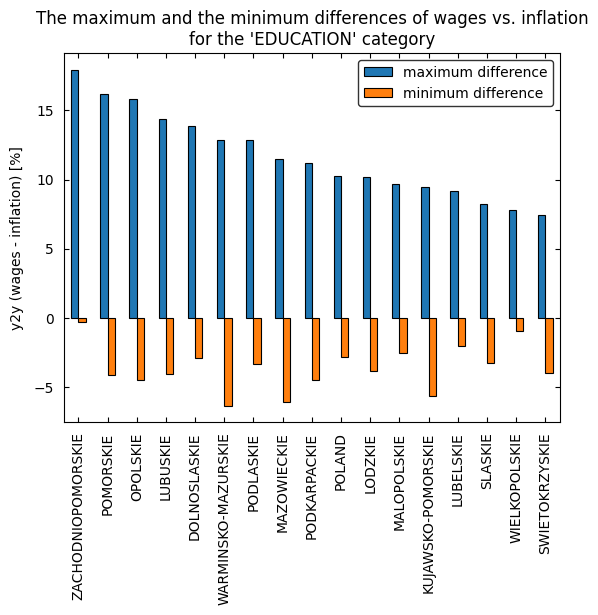

In [34]:
# show the extremes in the 'EDUCATION' category for the voivodeships
min_max_EDUC_plot = min_max_diff_Q['EDUCATION'].applymap(lambda x: x[1])\
    .sort_values('diff_max', ascending=False).plot(
    kind='bar', xlabel='', ylabel='y2y (wages - inflation) [%]', 
    title='The maximum and the minimum differences of wages vs. inflation\n'
    'for the \'EDUCATION\' category',
    linewidth=0.8, edgecolor='k'
)

min_max_EDUC_plot.legend(['maximum difference', 'minimum difference']);

To investigate the differences locally, i.e., within one chosen quarter, we can prepare the map for fixed date and label (voivodeship, section or good), annotating two remaining types of categories in the map axes. The example is shown below, where for 2020-Q4 one can see the results across the voivodeships and the goods, for the enterprise section fixed as the <font color=#ff7f0e>total</font> one.

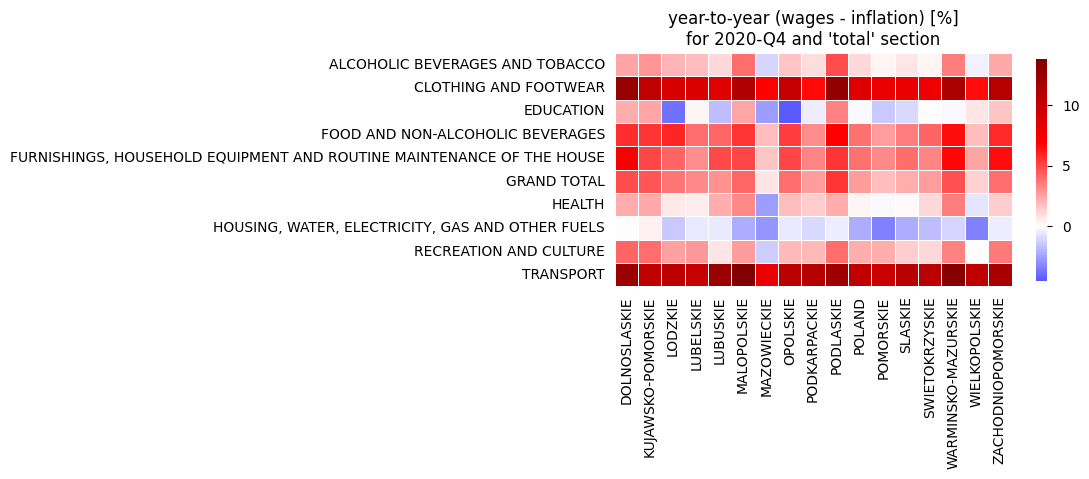

In [35]:
# collect the data for the map
y2y_Q_diff = y2y_Q_df.loc['2020-Q4'].query('section == "total"').pivot(
    index='good', columns='voivodeship', values='wage_infl_diff'
)

# plot the map
with plt.style.context({'ytick.direction': 'out'}):
    sns.heatmap(
        y2y_Q_diff, 
        center=0, square=True, 
        linewidths=0.4, linecolor='w', clip_on=False, 
        cmap='seismic', cbar_kws={'shrink': 0.6}
    ).set(xlabel='', ylabel='', title='year-to-year (wages - inflation) [%]\n'
        'for 2020-Q4 and \'total\' section')

plt.gca().tick_params(length=0)

The map shows, that in the considered quarter, all the voivodeships had problems within the <font color=#ff7f0e>HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS</font> category (values close or below zero), while the situation for <font color=#ff7f0e>TRANSPORT</font> was very good (maximum color scale). Choosing particular voivodeship(s), one can easily determine the categories of better and worse relations between the wages and the inflation.

To make the comparisons more practical, we introduce the `infl_wag_diff_plot` function, defined in the <a href='utils.py'>`utils.py`</a> module. The tool can produce two types of graphs, depending on the chosen parameters:\
(i) the map of (wages vs. inflation) differences, when particular quarter (the `period` parameter) and only one label from the available categories (parameter `voivodeship`, `section` or `good`) are chosen, or\
(ii) the bar plots of the differences distribution, when a slice of quarters and exactly two labels are selected (the remaining category serves as comparison attribute).

**Note**: In the second case (ii), the slice should be chosen as wide as possible, since the number of original records is very limited (four per year), and their further reduction will have an impact on the distribution quality.

The example of map corresponding to the first case (i) has been already shown in the upper cell for the <font color=#ff7f0e>total</font> section and 2020-Q4 (we could use `infl_wag_diff_plot(y2y_Q_df, period='2020-Q4', section='total')` instruction for ease). The example of bar plots comparison between the voivodeships (ii) is given as follows, for the 2011-Q1:2019-Q4 time frame (we exclude the COVID-19 period onwards), <font color=#ff7f0e>administrative and support service activities</font> section and <font color=#ff7f0e>FOOD AND NON-ALCOHOLIC BEVERAGES</font> category:

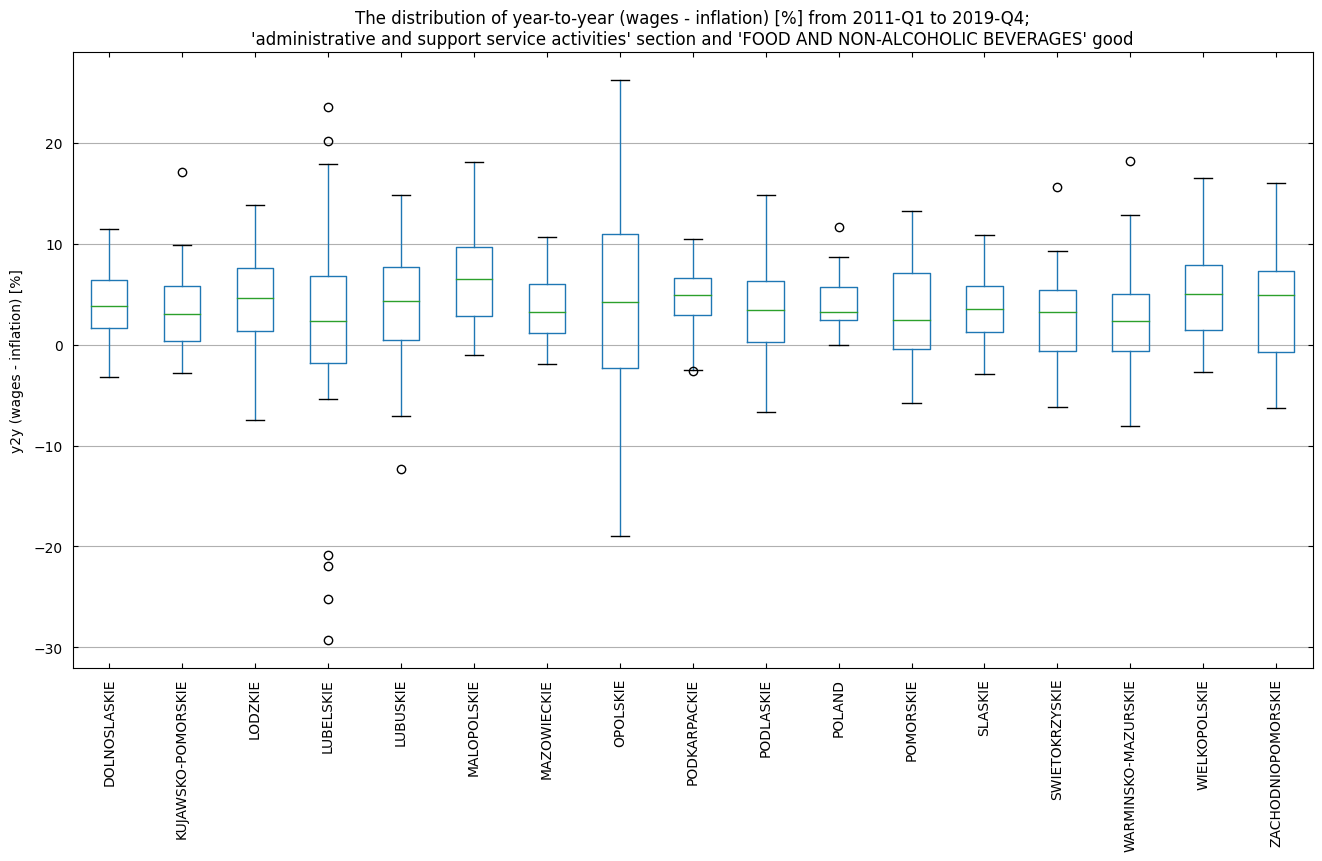

In [36]:
from utils import infl_wag_diff_plot

infl_wag_diff_plot(y2y_Q_df, period='2011-Q1:2019-Q4', 
    section='admin', good='FOOD');

The diagrams show, that the highest interquartile range of the differences can be observed in <font color=#ff7f0e>OPOLSKIE</font> region, while the <font color=#ff7f0e>LUBELSKIE</font> one reported the most extreme outliers, reaching even -30%. The 1st quartiles (the lower edges of the boxes) for most of the results are above (or close to) the zero level, which indicates a decent situation among the voivodeships. The medians (marked as green, horizontal bars within the boxes) are all above zero, i.e., in at least half of the quarters in each region, the differences were positive.

Using both maps and box plots, one can easily see how the consumers' situation varied between the voivodeships. The `infl_wag_diff_plot` function can be also used to compare other categories, depending on the chosen parameters (e.g., the map of *(section, good)* for fixed region).

### Wages and prices <a id='section_prices'></a>

The analysis of the relations between wages and inflation allows to assess the consumers' situation, indicating the periods, when the wages increased faster (or slower) than the prices. As we have seen, in a vast majority of months/quarters, mainly except 2022 and 2023, the inflation was beneath the wages levels, implying a stable growth of people wealth. However, the expression of the data in the form of indices (here, year-to-year) might be misleading, and does not present the full picture of the dynamics. We have observed this problem before, when comparing the cumulative increases of the wages in percentages and the total absolute wages between different sections of the enterprise sector (see [this](#cell_wages_q) cell above for details). For this reason, we have to incorporate the prices data.

In the final database query, we access the absolute prices of foodstuffs (the `prices_food` table) and non-foodstuffs (the `prices_non_food` table), combining them into one data frame. The first queried table contains the **voivodeship** column, since the foodstuffs prices are collected in relation to different regions (also including the aggregated category). Since the non-foodstuffs data are missing such participation (collection across the whole country only), we need to add the additional column for compatibility. The details on the original datasets can be found in the <a href="0-data_cleaning.ipynb">0-data_cleaning.ipynb</a> notebook.

After collecting the prices, we merge them with the wages for the final frame.

In [37]:
# query for the prices data
with sqlite3.connect('inflation_database.db') as connection:
    prices = pd.read_sql(
        """
        SELECT *
        FROM prices_food
        
        UNION
        
        SELECT
            date,
            'POLAND' AS voivodeship,
            good,
            price
        FROM prices_non_food
        """,
        connection, index_col='date', parse_dates='date'
    ).to_period('M')

# merge prices and wages
p_w_df = prices.merge(wages, how='left', on=['date', 'voivodeship'])
p_w_df.insert(p_w_df.shape[1] - 2, 'price', p_w_df.pop('price'))

p_w_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 643950 entries, 2010-01 to 2023-03
Freq: M
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   voivodeship  643950 non-null  object 
 1   good         643950 non-null  object 
 2   section      643950 non-null  object 
 3   price        638901 non-null  float64
 4   wage         643950 non-null  float64
dtypes: float64(2), object(3)
memory usage: 29.5+ MB


The DataFrame contains some nulls in the **price** column; these correspond to the goods, for which the monthly prices are partially missing. We have determined the latter ones while cleaning the data - see **The prices** section in the <a href="0-data_cleaning.ipynb">0-data_cleaning.ipynb</a> notebook. Since the gaps refer mainly to the front or the tail of the available time frame, we will just drop the problematic records.

In [38]:
prices.dropna(inplace=True)
p_w_df.dropna(inplace=True)

We can start with a short analysis of the prices only, using the `prices` data frame queried above. During the investigations on the inflation data (included in the previous notebook), we have partially studied how the prices changed, using the monthly inflation indicators of particular goods. However, the previous datasets referred only to the general level prices, regardless the voivodeships, and the categories of goods were rather general. Using the current data, we can compare the dynamics of goods between different regions and make the analysis more detailed.

Since the original data includes both foodstuffs and non-foodstuffs, and the latter ones are provided only on the general level of the whole country, we can separate the labels for practical use.

In [39]:
# foodstuffs
f_labels = [good for good in prices.good.unique() if not
    prices.query(f'voivodeship == "MAZOWIECKIE" and good == "{good}"').empty]

# non-foodstuffs
nf_labels = [label for label in prices.good.unique() if label not in f_labels]

The dynamics of prices can be easily presented using line plots, for various categories fixed. We can select different types of goods and visualize how their prices changed within a chosen region, or on the general level. This type of comparison is shown for five products globally (the <font color=#ff7f0e>POLAND</font> level) in the left panel in the figure below. On the other hand, when fixing particular type of good, we can see how its price varied between the voivodeships; the example is enclosed in the right panel in the figure below, for randomly selected four regions and the prices of <font color=#ff7f0e>milk</font>.

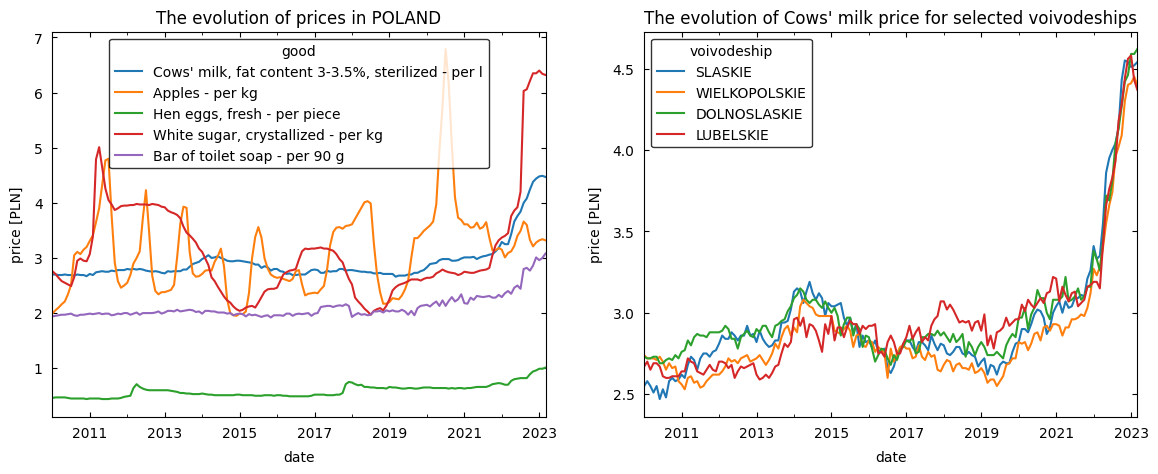

In [40]:
# select products and random voivodeships
goods = label_shorthands(prices, ['milk', 'Apples', 
    'eggs', 'sugar', 'soap'], 'good')

np.random.seed(0)
voivs = np.random.choice(prices.voivodeship.unique(), 4)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plot prices on the global level (POLAND)
prices.query('voivodeship == "POLAND"').pivot(
    columns='good', values='price'
)[goods].plot(
    title='The evolution of prices in POLAND', ylabel='price [PLN]', 
    ax=axes[0]
)

# plot prices of milk within the drawn voivodeships
prices.query(f'good == "{goods[0]}"').pivot(
    columns='voivodeship', values='price'
)[voivs].plot(
    title=f'The evolution of {goods[0][:10]} price for selected voivodeships', 
    ylabel='price [PLN]', ax=axes[1]
);

We can easily determine the products with the largest increases in their price for any chosen region and time frame. The result presented below includes the top growths in the whole time interval (2010-2023) and the general level of Poland. The goods, for which the beginning (2010-01) or the ending (2023-03) price is missing are excluded for compatibility with other products.

In [41]:
# a tool function to compare how the price changed (relative difference in %)
def price_diff(series, i, j):
    # the relative difference between the j-th and the i-th value in the series
    return 100 * (series[j] - series[i]) / series[i]

# the largest increases
p_max_incr = prices.query('voivodeship == "POLAND"')\
    .loc[['2010-01', '2023-03']].groupby('good').price\
    .agg(lambda x: price_diff(x, 0, 1) if x.size > 1 else np.nan)\
    .dropna().sort_values(ascending=False)

p_max_incr.head(10)

good
Washing powder – per 300 g                                              851.38
Onions - per kg                                                         277.85
Fridge-freezer, capacity about 440 l                                    186.15
Consultation of a specialist doctor                                     177.00
Men's hair-cutting                                                      168.68
Carrots - per kg                                                        167.48
Wheat flour - per kg                                                    160.11
Wheat-rye bread - per 0.5 kg                                            157.22
Stamp for unregistered letter, standard domestic delivery, up to 50 g   151.61
Bed-linen laundering – per kg [zl]                                      142.35
Name: price, dtype: float64

As can be seen, the highest result corresponds to the washing powder, for which the price has increased from Jan 2010 to Mar 2023 more than 9.5 times (851.38% growth). However, it can be easily checked, that the price remained quite stable for a very long time, and then rapidly spiked in Jan 2022. Such enormous increase might suggest a glitch in the original dataset, especially since the current price of the washing powder (as of May 2023) is much more lower than the one suggested by the data.

Since we observe unusual increases in prices from 2022 onwards, we will split and compare the changes within two time intervals, as shown in the bar plots enclosed below. In the first scenario, we calculate the changes in prices between Jan 2010 and Dec 2021 - these results correspond to the blue bars. In the second case, the changes are determined within 2022-2023 only (from Dec 2021 to Mar 2023), as marked by the orange bars. The chosen goods correspond to the top ten highest increases within the whole 2010-2023 interval, excluding the washing powder for readability of the bars (scaling).

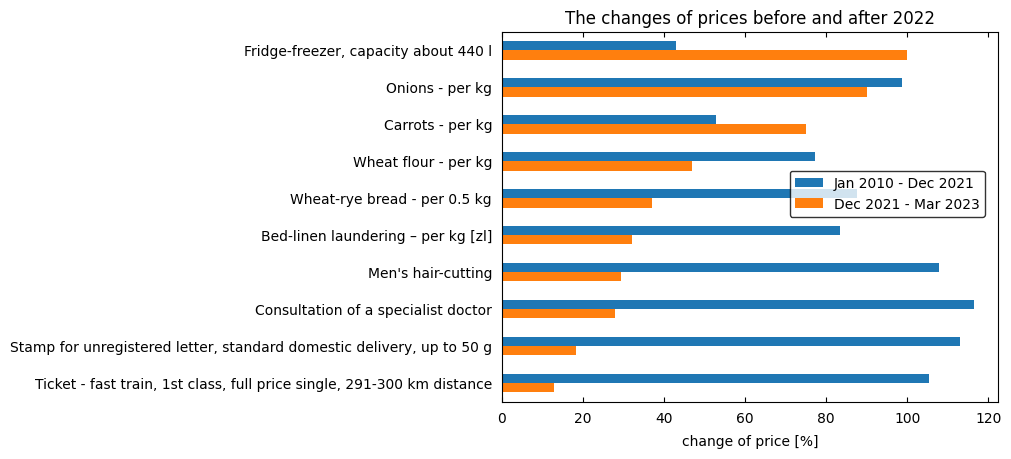

In [42]:
# the list of products
top_10 = list(p_max_incr.iloc[1:11].index)

# the data
p_max_incr2 = prices.query(f'voivodeship == "POLAND" and good.isin({top_10})')\
    .loc[['2010-01', '2021-12', '2023-03']]\
    .groupby('good').price.agg(
        diff_2010_2021=lambda x: price_diff(x, 0, 1), 
        diff_2021_2023=lambda x: price_diff(x, 1, 2)
    ).sort_values(by='diff_2021_2023', ascending=False)

# the bar plots
ax = p_max_incr2.plot(
    kind='barh', 
    xlabel='change of price [%]', ylabel='', 
    title='The changes of prices before and after 2022'
)

ax.invert_yaxis()  # sort the bars in the right order (blue above the orange)
ax.tick_params(axis='y', length=0)
plt.legend(['Jan 2010 - Dec 2021', 'Dec 2021 - Mar 2023'], loc=(0.58, 0.5));

In many cases, the (cumulative) growths before 2022 were higher than the ones occurring between Dec 2021 and Mar 2023. However, the scale of the bars show, that among various products, the increases within 2022-2023 alone have been at least 1/2-1/4 as big, as the total increases over the previous 12 years (2010-2021).

We can easily observe how the prices are distributed across the years using binning; instead of histograms, in this case we will use a pie chart and focus on the <font color=#ff7f0e>white sugar</font> price (see also the red curve in the line plot shown above - the left panel). The values are split into five equal bins, and for each one of them, we calculate the number of months when the price was within the considered range. Having the results categorized, we can plot the pie.

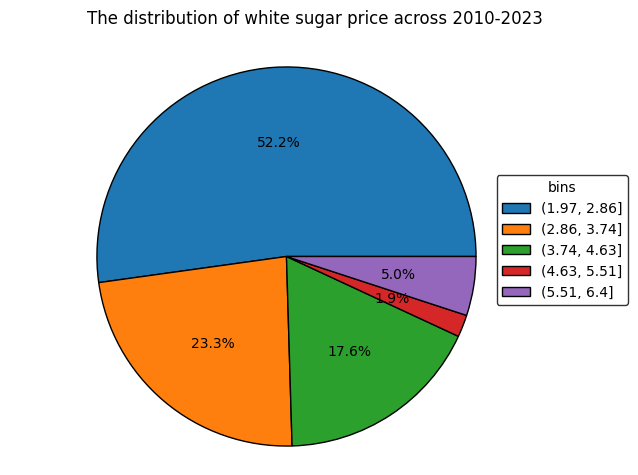

In [43]:
# query for sugar and get the bins
sugar_df = prices.query('voivodeship == "POLAND" '
    f'and good.str.contains("sugar")').assign(
    bin_cats=lambda x: pd.cut(x.price, bins=5, precision=2)
)
sugar_bins = sugar_df.bin_cats.value_counts(normalize=True).sort_index()

# plot the pie chart
sugar_pie = plt.pie(
    sugar_bins, autopct='%.1f%%', 
    wedgeprops = {"edgecolor" : "black"}, labeldistance=None
)

# improve the plot
plt.gca().axis("equal")
plt.suptitle('The distribution of white sugar price across 2010-2023')

labels = sugar_bins.index
plt.legend(
    sugar_pie[0], labels, title='bins', 
    bbox_to_anchor=(1.0, 0.5), loc="center right", 
    bbox_transform=plt.gcf().transFigure
)

plt.tight_layout()

As one can see, in more than a half of the months, the prices were at the lowest level (below 2.86 PLN). The second (orange) bin contains almost quarter of the values. The highest prices account for only 5% of the months, but unfortunately, these are the most recent ones.

In the examples presented above we have focused on the general level of prices (the <font color=#ff7f0e>POLAND</font> category). To compare the price increases between the voivodeships, we have to limit the goods to foodstuffs only (the prices of non-foodstuffs are collected globally, regardless the regions). In this setup, the records for all of the dates are available, so we don't have to worry about the NaNs. The next data frame contains the total (percentage) increases of the prices within 2010-2023, split for both the products (rows) and the voivodeships (columns).

In [44]:
# calculate the price increases within the goods and the voivodeships
p_incr_voiv = prices.query(f'good.isin({f_labels})')\
    .loc[['2010-01', '2023-03']].pivot_table(
    index='voivodeship', columns='good', values='price', 
    aggfunc=lambda x: price_diff(x, 0, 1),
).T

p_incr_voiv.sample(5, random_state=0)  # show a sample only

voivodeship,DOLNOSLASKIE,KUJAWSKO-POMORSKIE,LODZKIE,LUBELSKIE,LUBUSKIE,MALOPOLSKIE,MAZOWIECKIE,OPOLSKIE,PODKARPACKIE,PODLASKIE,POLAND,POMORSKIE,SLASKIE,SWIETOKRZYSKIE,WARMINSKO-MAZURSKIE,WIELKOPOLSKIE,ZACHODNIOPOMORSKIE
good,,,,,,,,,,,,,,,,,
"Hen eggs, fresh - per piece",102.13,119.57,112.77,126.09,111.90,128.26,109.80,113.64,138.64,120.41,119.57,110.20,133.33,94.00,113.04,127.91,100.00
"Fresh butter, fat content about 82.5% - per 200 g",78.33,80.34,69.73,83.50,80.40,67.87,82.17,83.84,88.32,67.70,75.67,55.11,63.29,92.93,83.54,89.34,56.15
Wheat-rye bread - per 0.5 kg,143.48,151.43,132.28,117.55,199.46,168.88,146.59,147.29,157.23,159.88,157.22,173.18,171.96,176.73,198.79,169.11,149.74
Pearl-barley - per 0.5 kg,124.86,130.82,110.53,84.04,175.16,102.35,101.92,111.36,185.26,120.81,111.60,96.07,121.51,92.02,112.81,123.12,35.96
Smoked sausage - per kg,113.64,134.29,116.13,94.99,112.85,95.08,93.57,91.14,97.15,108.34,105.94,125.84,104.27,83.90,99.31,102.59,114.98


To indicate the extremes in the prices, we define the following `find_records` function, which for each type of product returns the list of three voivodeships with the highest product prices (including the prices also), and the region, where the good was the cheapest. We apply the function to the absolute values of prices in the ending period of Mar 2023.

**Note**: The function accounts for the possibility of ties (which in fact occur, as shown below).

In [45]:
def find_records(series):
    """
    Find the three most expensive voivodeships and the cheapest one 
    for selected product.
    """
    series = series.sort_values(ascending=False)
    recs = []

    # get the highest three prices and examine possible ties
    for i in range(3):
        recs.append(series.iloc[[i]].index[0])
        recs.append(series[i])
    for i in range(3, series.size):
        if series[i] == series[i-1]:
            recs[4] = recs[4] + ' & ' + series.iloc[[i]].index[0]
        else:
            break
    
    # get the lowest price and examine possible ties
    recs.append(series.iloc[[-1]].index[0])
    recs.append(series[-1])
    for i in range(series.size - 1, -1, -1):
        if series[i] == series[i-1]:
            recs[6] = recs[6] + ' & ' + series.iloc[[i-1]].index[0]
        else:
            break
    
    return recs

# find the extremes among the voivodeships
price_recs = prices.query('voivodeship != "POLAND" '
    f'and good.isin({f_labels})').loc['2023-03']\
    .pivot(index='voivodeship', columns='good', values='price')\
    .apply(lambda x: find_records(x))

# improve the data frame index
price_recs.index = [*['1st']*2, *['2nd']*2, *['3rd']*2, *['last']*2]
price_recs.index.name = 'voivodeship'

price_recs.T

voivodeship,1st,1st,2nd,2nd,3rd,3rd,last,last
good,,,,,,,,
Apple juice - per l,LODZKIE,4.77,WIELKOPOLSKIE,4.61,WARMINSKO-MAZURSKIE,4.60,ZACHODNIOPOMORSKIE,3.89
Apples - per kg,WIELKOPOLSKIE,3.77,ZACHODNIOPOMORSKIE,3.69,KUJAWSKO-POMORSKIE,3.66,PODKARPACKIE,2.78
"Beef meat, bone-in - per kg",OPOLSKIE,42.15,ZACHODNIOPOMORSKIE,39.14,SLASKIE,37.90,WARMINSKO-MAZURSKIE,30.77
"Beef meat, boneless - per kg",WIELKOPOLSKIE,50.39,LUBUSKIE,50.04,ZACHODNIOPOMORSKIE,48.21,SWIETOKRZYSKIE,42.45
Beetroots - per kg,ZACHODNIOPOMORSKIE,3.62,LUBUSKIE,3.59,OPOLSKIE,3.56,MALOPOLSKIE,2.59
Carrots - per kg,OPOLSKIE,4.73,SWIETOKRZYSKIE,4.68,POMORSKIE,4.56,KUJAWSKO-POMORSKIE,4.10
Cottage cheese - per kg,LUBUSKIE,23.13,MAZOWIECKIE,21.08,SLASKIE,21.00,OPOLSKIE,17.65
"Cows' milk, fat content 3-3.5%, sterilized - per l",MAZOWIECKIE,4.71,MALOPOLSKIE,4.63,DOLNOSLASKIE,4.62,ZACHODNIOPOMORSKIE,4.09
Disembowelled chicken - per kg,MALOPOLSKIE,14.85,DOLNOSLASKIE,13.02,WARMINSKO-MAZURSKIE,12.84,SLASKIE,10.61


Each row in the frame presented above allows to compare the most expensive voivodeships with the cheapest one for chosen product. To get the general overview of the regions, in the next cell we enclose three simple aggregations of the obtained data frame:\
(i) the distribution of voivodeships with the highest prices across all the products (the 1st place),\
(ii) the distribution of voivodeships with the lowest prices across all the products (the last place), and\
(iii) the percentage (**pct_diff**) and the absolute (**abs_diff**) differences between the highest and the lowest price of each product.

In [46]:
# (i) the voivodeships with the highest prices
display(price_recs.iloc[0].value_counts())

# (ii) the voivodeships with the lowest prices
display(price_recs.iloc[-2].value_counts())

# (iii) the percentage and absolute differences between the extremes
p_r_diff = price_recs.apply(lambda x: (price_diff(x, -1, 1), x[1] - x[-1])).T
p_r_diff.columns = ['pct_diff', 'abs_diff']
p_r_diff.sort_values('pct_diff', ascending=False)

POMORSKIE             4
OPOLSKIE              3
SWIETOKRZYSKIE        3
DOLNOSLASKIE          3
WIELKOPOLSKIE         2
ZACHODNIOPOMORSKIE    2
LODZKIE               1
LUBUSKIE              1
MAZOWIECKIE           1
MALOPOLSKIE           1
PODLASKIE             1
PODKARPACKIE          1
SLASKIE               1
Name: 1st, dtype: int64

ZACHODNIOPOMORSKIE     5
PODKARPACKIE           5
SWIETOKRZYSKIE         3
KUJAWSKO-POMORSKIE     2
OPOLSKIE               2
LUBELSKIE              2
WARMINSKO-MAZURSKIE    1
MALOPOLSKIE            1
SLASKIE                1
LUBUSKIE               1
LODZKIE                1
Name: last, dtype: int64

,pct_diff,abs_diff
good,,
Pearl-barley - per 0.5 kg,61.23,1.69
Oranges - per kg,46.89,2.79
Poultry sirloin - per kg,45.13,10.65
Wheat-rye bread - per 0.5 kg,42.30,1.73
Disembowelled chicken - per kg,39.96,4.24
Beetroots - per kg,39.77,1.03
"Beef meat, bone-in - per kg",36.98,11.38
Apples - per kg,35.61,0.99
Smoked sausage - per kg,31.64,8.11


The last result shows, that the voivodeships can differ in prices even up to 60%. However, the comparison should also take into account the absolute differences (the **abs_diff** column), since these indicate how much money the customer will pay more (or less) for chosen products.

Now let's get to the complete `p_w_df` data frame with both prices and wages included. We introduce the **wealth** coefficient, which for each record denotes the ratio between the wage and the price. The parameter can be used a simple measure of the customer's situation on the market, i.e., it describes how many items of particular good the customer was able to buy using the whole wage.

In [47]:
# add the column of wealth
p_w_df = p_w_df.assign(wealth=lambda x: x.wage/x.price)

p_w_df.sample(3, random_state=0)

,voivodeship,good,section,price,wage,wealth
date,,,,,,
2019-09,PODKARPACKIE,Cottage cheese - per kg,construction,14.03,4190.44,298.68
2017-06,SWIETOKRZYSKIE,Cottage cheese - per kg,administrative and support service activities,11.46,2672.04,233.16
2020-08,POMORSKIE,Disembowelled chicken - per kg,administrative and support service activities,6.80,3934.57,578.61


We can start from visualizing the evolution of wealth for chosen types of goods, focusing first on the global level of prices (voivodeship as <font color=#ff7f0e>POLAND</font>) and total wages across the sector (section as <font color=#ff7f0e>total</font>).

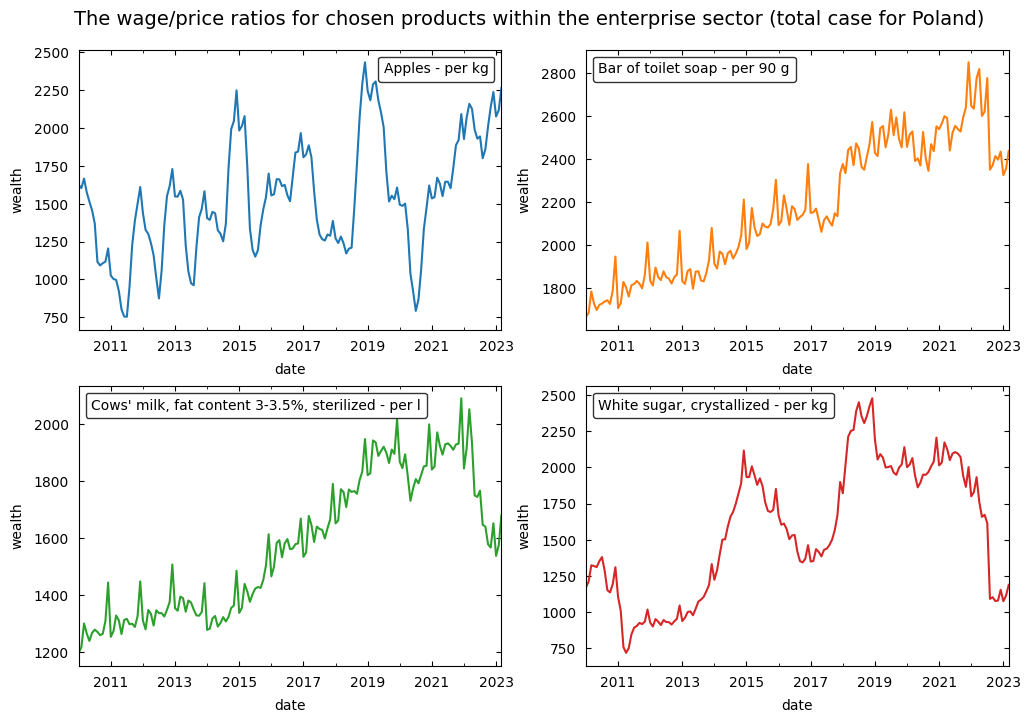

In [48]:
# select the products
goods = label_shorthands(prices, ['milk', 'Apples', 'sugar', 'soap'], 'good')

# plot the wealth
ax = p_w_df.query(f'voivodeship == "POLAND" and good.isin({goods}) '
    'and section == "total"')\
    .pivot(columns='good', values='wealth').plot(
    subplots=True, layout=(2, 2), figsize=(12, 8), 
    sharex=False, ylabel='wealth'
)

for ax in ax.flatten():
    ax.legend(handlelength=0, handletextpad=0)

plt.suptitle('The wage/price ratios for chosen products within '
    'the enterprise sector (total case for Poland)', y=0.93, fontsize=14);

When the price is stable and the wages increase, we can observe a general growth of the wealth, as shown in the cases of <font color=#ff7f0e>milk</font> (green) and <font color=#ff7f0e>soap</font> (orange), excluding the declines in 2022 onwards, when the prices started to increase. On the other hand, the fluctuations of the prices can influence the wealth in different ways, depending on the dynamics of wages. This scenario can be found for <font color=#ff7f0e>apples</font> (blue) and <font color=#ff7f0e>sugar</font> (red), for which the wealth coefficient varied in time.

Focusing on particular good, one can compare the wealth between the voivodeships, as shown for <font color=#ff7f0e>milk</font> in the bar plot below (the general <font color=#ff7f0e>POLAND</font> level is annotated by red color in the horizontal axis). The blue and the orange bars correspond to the wealth coefficients calculated for the wages and the prices in Jan 2010 and Mar 2023, respectively. The value above each pair of bars describes the percentage change between them, i.e., how the wealth changed (here, increased) within 13 years (values sorted in descending order).

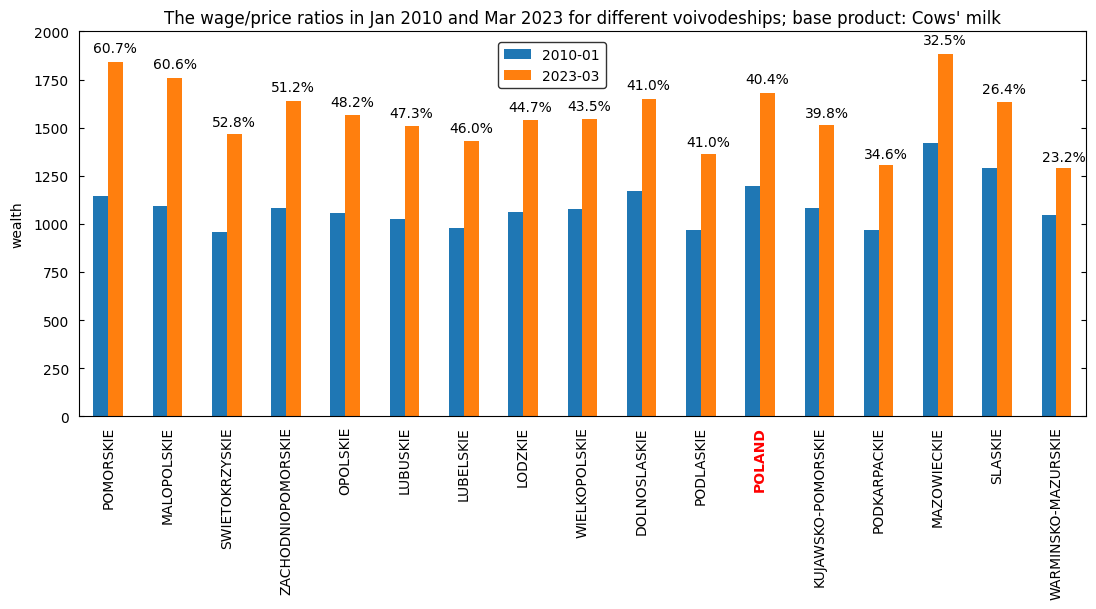

In [49]:
# get the milk data
p_w_voiv_milk = p_w_df.query(f'good == "{goods[0]}" and section == "total"')

# get the differences
p_w_diff = p_w_voiv_milk\
    .pivot(columns='voivodeship', values='wealth').iloc[[0, -1],].T\
    .assign(diff=lambda x: 100 * (x['2023-03'] - x['2010-01']) / x['2010-01'])\
    .sort_values('diff', ascending=False)

# plot the bars
ax = p_w_diff.drop(columns='diff').plot.bar(
    figsize=(13, 5), xlabel='', ylabel='wealth', 
    title='The wage/price ratios in Jan 2010 and Mar 2023 for '
          f'different voivodeships; base product: {goods[0][:10]}'
)

# annotate the POLAND label
for label in ax.get_xticklabels():
    if label.get_text() == 'POLAND':
        label.set(color='red', weight='bold')

# add percentage changes
for i in range(p_w_diff.shape[0]):
    p_0 = ax.patches[i]
    p_1 = ax.patches[i + 17]
    ax.text(
        p_0.get_x(), 
        p_1.get_height() * 1.03, 
        f'{p_w_diff["diff"][i]:.1f}%'
    )

plt.ylim(0, 2000)
ax.tick_params(axis='x', length=0)
ax.legend(bbox_to_anchor=(0.53, 0.99));

To get the general overview of the wealth across the whole [2010, 2023] time interval, we can calculate the basic statistics within each voivodeship as follows (the results are sorted descending by the mean):

In [50]:
p_w_voiv_milk.groupby('voivodeship').wealth\
    .describe().T.sort_values('mean', axis=1, ascending=False)

voivodeship,MAZOWIECKIE,POMORSKIE,SLASKIE,POLAND,DOLNOSLASKIE,MALOPOLSKIE,ZACHODNIOPOMORSKIE,WIELKOPOLSKIE,LODZKIE,OPOLSKIE,LUBUSKIE,SWIETOKRZYSKIE,KUJAWSKO-POMORSKIE,LUBELSKIE,PODLASKIE,PODKARPACKIE,WARMINSKO-MAZURSKIE
count,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00,159.00
mean,1807.74,1717.50,1618.35,1572.17,1569.42,1516.70,1509.81,1455.77,1451.12,1426.07,1399.68,1361.80,1337.28,1326.16,1278.71,1259.02,1251.52
std,249.29,340.44,237.76,242.30,281.86,282.75,302.34,231.96,247.46,235.37,268.86,269.32,210.18,164.53,200.28,191.14,170.68
min,1419.11,1139.31,1245.77,1196.43,1139.24,1095.20,1084.56,1077.49,1051.80,1056.18,1023.32,959.43,1047.70,980.67,968.61,966.91,993.09
25%,1573.35,1428.53,1413.80,1336.14,1286.55,1234.79,1220.82,1245.00,1213.51,1176.85,1127.99,1102.78,1133.26,1189.12,1113.51,1084.62,1093.70
50%,1797.47,1776.44,1583.01,1565.74,1574.07,1535.66,1505.63,1405.78,1452.31,1467.49,1385.63,1306.69,1316.65,1316.67,1248.27,1228.81,1219.84
75%,2038.93,2023.92,1827.06,1796.93,1815.72,1769.92,1783.96,1699.94,1675.65,1658.43,1648.55,1635.98,1510.55,1457.66,1450.28,1446.12,1411.22
max,2290.26,2347.81,2277.14,2089.43,2221.34,2065.24,2173.65,1920.94,1977.86,1897.77,1990.80,1903.29,1812.27,1824.41,1780.74,1655.39,1638.49


The <font color=#ff7f0e>MAZOWIECKIE</font> voivodeship has the largest mean, but also all the quartiles, which suggests, that it exceeds (on average) the rest of the regions, at least in the abilities of purchasing milk. The comparison can be easily expressed using histograms as follows:

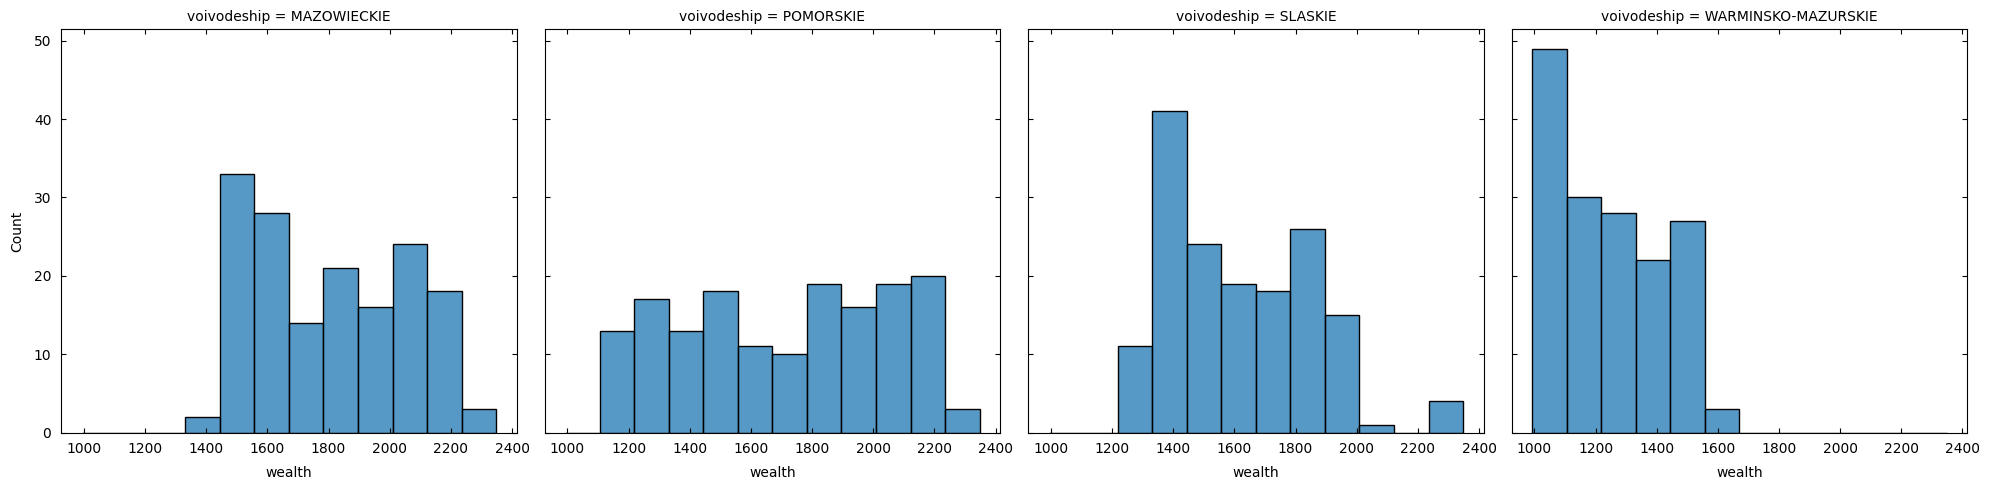

In [51]:
# the list of selected voivodeships
voivs = ['MAZOWIECKIE', 'POMORSKIE', 'SLASKIE', 'WARMINSKO-MAZURSKIE']

# plot histograms
fg = sns.displot(
    p_w_voiv_milk.query(f'voivodeship.isin({voivs})'), 
    x='wealth', col='voivodeship', 
    kind='hist'
)

# improve the layout
for ax in fg.axes.flatten():
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(True)

As can be seen, the bars for <font color=#ff7f0e>MAZOWIECKIE</font> region are shifted towards the highest values, compared to the other diagrams. The <font color=#ff7f0e>WARMINSKO-MAZURSKIE</font> voivodeship settles around the smallest wealth, while the results within <font color=#ff7f0e>SLASKIE</font> and <font color=#ff7f0e>POMORSKIE</font> reside in the middle.

To get a more comprehensive comparison between the voivodeships or the sections, we add to our <a href='utils.py'>`utils.py`</a> module the `wealth_plot` function. The tool requires to choose a singular type of good, and depending on the scenario:\
(i) one voivodeship and two sections (when comparing the enterprise sector sections), or\
(ii) one section and two voivodeship (when comparing the regions).

Determining time interval (Jan 2010 - Mar 2023 by default), we can observe the line plots of the absolute wages and wealth for chosen categories (the wealth calculated in reference to fixed good), as well as the relation between the wages ratio and the product price. The latter one is presented in the form of scatter and hexbin plots.

The example for <font color=#ff7f0e>milk</font> and two sections: <font color=#ff7f0e>professional, scientific and technical activities</font> and <font color=#ff7f0e>administrative and support service activities</font>, with the wages provided regardless the voivodeship (the global <font color=#ff7f0e>POLAND</font> level) is presented in the cell below.

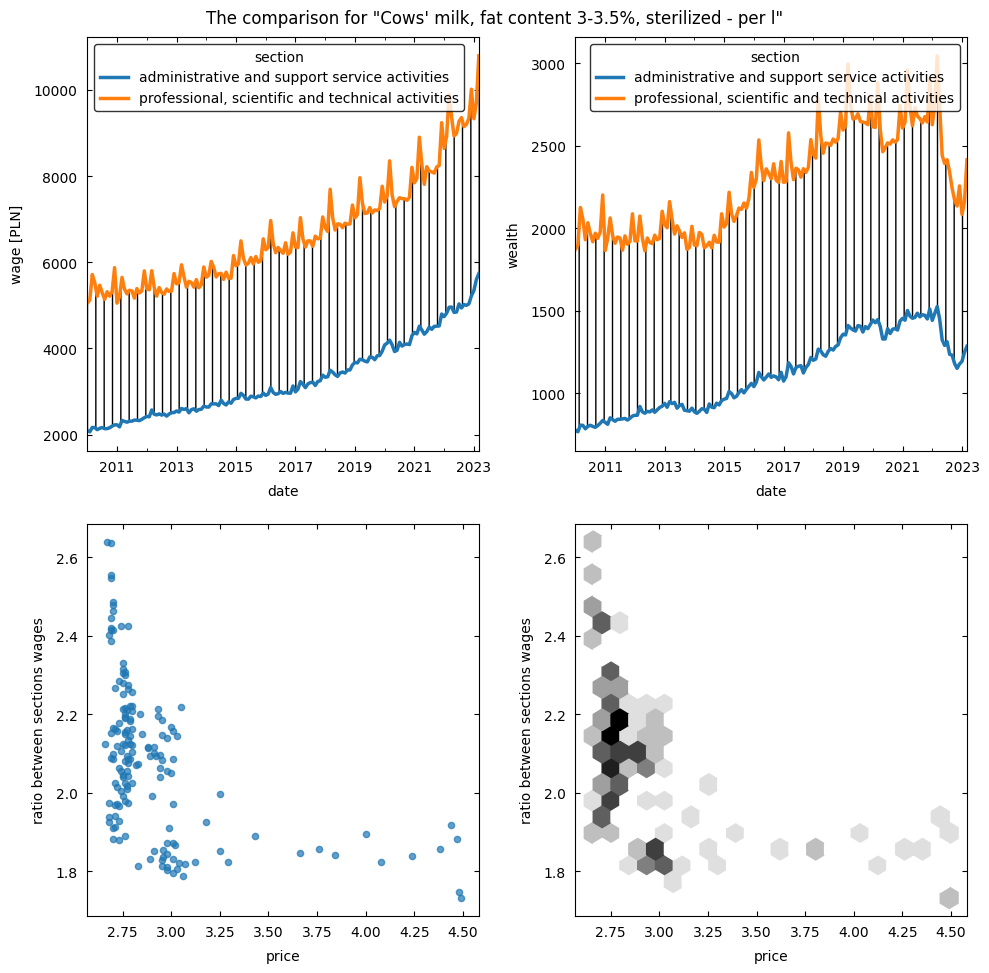

In [52]:
from utils import wealth_plot

wealth_plot(p_w_df, good='milk', 
    sections=['professional', 'admin'], voivodeships='POLAND');

The plots for the wages and the wealth (in the upper left and upper right corners, respectively) show, that the situation of the <font color=#ff7f0e>professional</font> section was always better, than the <font color=#ff7f0e>administrative</font> one (the differences are marked using vertical lines). The details on the relations between these two can be found in the lower subplots, where for each month we plot <font color=#ff7f0e>the ratio between the wages</font> (in the vertical axis) vs. <font color=#ff7f0e>the milk price</font> (in the horizontal axis). Focusing on the left subfigure, we can see, that the wages among the professionals were at least as high, as approximately 180% of the wages of administration. The scatter plot includes also the price absolute values, that shape the wealth coefficient introduced above. In this case, the largest prices of milk correspond to the lowest wages ratios, which is beneficial for the administration. In contrast, the appearance of points in the right upper corner of the plot (both high price and the ratio) would simulate the situation, when the gap (in the sense of wealth) between the sections increases, since the administration workers would have to pay a high price of the product, with the wage much smaller than the professional ones. The distribution of the (real) scenarios can be observed more clearly in the hexbin plot (the lower right corner subfigure), where we indicate how the cases accumulate (the hexbin plot projects a two-dimensional histogram onto a plane with chosen color scale). The darker the hexbin, the denser accumulation of the points.

The `wealth_plot` function introduced above can be used to compare any two types of sections, as well as two voivodeships, when the section is fixed.

We conclude our investigations with a simple tool, that allows to calculate the wealth in relation to a basket of goods, i.e., the `basket_plot` function from the <a href='utils.py'>`utils.py`</a> module.

The function requires to fix both the voivodeship and the section, and provide the basket of chosen products in the form of dictionary - the `goods_dict` parameter, where each key corresponds to the product name (can be provided partially), while the value to its amount in the basket. As the result, we obtain the line plots of the wealth in chosen voivodeship, as well as globally (the <font color=#ff7f0e>POLAND</font> case for comparison), based on the basket price within each month.

**Note**: The prices of non-foodstuffs are available for the whole country only. When chosen, the price for the voivodeship is considered as the global one (the <font color=#ff7f0e>POLAND</font> level). For the comparison to work, we have to provide at least one foodstuff.

The list of all the available products is given below:

In [53]:
products = pd.DataFrame(nf_labels, columns=['non-foodstuffs'])
products['foodstuffs'] = pd.Series(f_labels)
products.iloc[:, ::-1]

,foodstuffs,non-foodstuffs
0,Apple juice - per l,"'Doxycyclinum', capsules 0.1g 10 pcs"
1,Apples - per kg,"'Geriavit', capsules 100 pcs"
2,"Beef meat, bone-in - per kg","'Ibuprofen', coated tablets 200 mg 60 pcs"
3,"Beef meat, boneless - per kg",Automatic washing machine
4,Beetroots - per kg,Bar of toilet soap - per 90 g
5,Carrots - per kg,"Bed linen, cotton 100% (three part set, linen-..."
6,Cottage cheese - per kg,Bed-linen laundering – per kg [zl]
7,"Cows' milk, fat content 3-3.5%, sterilized - p...","Bus ticket, ordinary national transportation, ..."
8,Disembowelled chicken - per kg,Children’s low leather shoes with non-leather ...
9,"Filets of hake, frozen - per kg",Cinema ticket


The example presented in the last cell for <font color=#ff7f0e>MAZOWIECKIE</font> voivodeship (regardless the enterprise sector section) involves a simple basket of fruits and vegetables (the amounts given in kilograms), with additional packs of sugar and flour (one kilogram each). In this case, the wealth in the region was always higher than the average one.

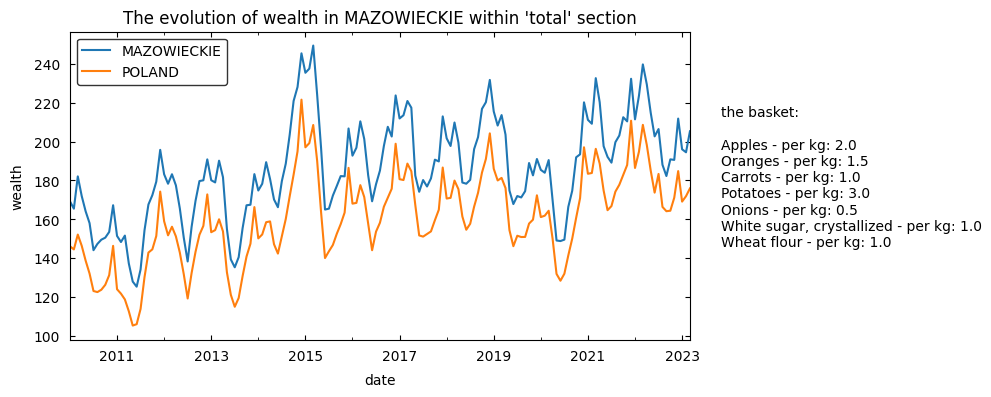

In [54]:
from utils import basket_plot

basket = {
    'Apples': 2.0, 'Oranges': 1.5, 
    'Carrots': 1.0, 'Potatoes': 3.0, 'Onions': 0.5, 
    'sugar': 1.0, 'flour': 1.0
}

basket_plot(p_w_df, voivodeship='MAZOWIECKIE', section='total', 
    goods_dict=basket);